In [92]:
# Import libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
import plotly.graph_objects as go
import plotly.express as px
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
plt.style.use("seaborn-whitegrid")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')
train['ind'] = 1
test['ind'] = 0
df= pd.concat([train, test])
df

num=test.select_dtypes(exclude='object')
cat=train.select_dtypes('object')

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [93]:
train.shape,test.shape

((74005, 77), (28085, 76))

In [94]:
# # Chekcing the percentage of Null values in all the columns
# getting list of columns with Null Values again
print(round(df.isnull().sum()/len(df.index)*100,2).sort_values(ascending=False)[ round(df.isnull().sum()/len(df.index),2) > 0 ] )

UvAerosolLayerHeight_solar_zenith_angle                     93.33
UvAerosolLayerHeight_solar_azimuth_angle                    93.33
UvAerosolLayerHeight_aerosol_pressure                       93.33
UvAerosolLayerHeight_aerosol_optical_depth                  93.33
UvAerosolLayerHeight_sensor_zenith_angle                    93.33
UvAerosolLayerHeight_sensor_azimuth_angle                   93.33
UvAerosolLayerHeight_aerosol_height                         93.33
emission                                                    27.51
Cloud_surface_albedo                                         3.78
Cloud_sensor_zenith_angle                                    3.78
Cloud_solar_zenith_angle                                     3.78
Cloud_solar_azimuth_angle                                    3.78
Cloud_sensor_azimuth_angle                                   3.78
Cloud_cloud_optical_depth                                    3.78
Cloud_cloud_base_height                                      3.78
Cloud_clou

In [95]:
useless=['UvAerosolLayerHeight_aerosol_height',
'UvAerosolLayerHeight_aerosol_pressure',
'UvAerosolLayerHeight_aerosol_optical_depth',
'UvAerosolLayerHeight_sensor_zenith_angle',
'UvAerosolLayerHeight_sensor_azimuth_angle',
'UvAerosolLayerHeight_solar_azimuth_angle',
'UvAerosolLayerHeight_solar_zenith_angle',]
df.drop(columns=useless,axis=1,inplace=True)


In [96]:

def getMonth(year: int, week: int) -> int:

    """Return the month number in the given week in the given year."""
    return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month
df['month'] = df.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)

df['location'] = df['latitude'].astype(str) + '_' + df['longitude'].astype(str)
df.drop(['latitude','longitude'],axis=1,inplace=True)

df['emission'].loc[df['emission'] >=6700]  = 6700

In [97]:
df.emission.value_counts()

6700.000000    12478
1.037306           3
3.519682           3
1.006891           3
1.007384           3
               ...  
5713.338400        1
5693.336000        1
5602.822800        1
5856.884300        1
28.858446          1
Name: emission, Length: 60664, dtype: int64

In [98]:


df.fillna(0,inplace=True)
df['sin_weekofyear'] = np.sin(2 * np.pi * df['week_no'] / 52)
df['cos_weekofyear'] = np.cos(2 * np.pi * df['week_no'] / 52)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1 # periodoc and include bias = True
    return SplineTransformer(degree=degree,
                            n_knots=n_knots,
                            knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
                            extrapolation="periodic",
                            include_bias=True)    

spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 4)]
sp_weekofyear = [f"cyclic_week_no_spline_{i}" for i in range(1, 27)]


df[spline_cols_month] = periodic_spline_transformer(12, n_splines=3).fit_transform(np.array(df.month).reshape(-1,1))
df[sp_weekofyear] = periodic_spline_transformer(52, n_splines=26).fit_transform(np.array(df.week_no).reshape(-1,1))

  


In [99]:
train = df[df.ind == 1]
test = df[df.ind == 0]

In [100]:

top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(30)
top20_corrs

emission                                                    1.000000
NitrogenDioxide_tropospheric_NO2_column_number_density      0.320929
NitrogenDioxide_NO2_column_number_density                   0.307791
NitrogenDioxide_NO2_slant_column_number_density             0.263495
SulphurDioxide_SO2_column_number_density_amf                0.118950
Ozone_O3_effective_temperature                              0.085552
UvAerosolIndex_sensor_altitude                              0.084181
Cloud_surface_albedo                                        0.072777
Formaldehyde_HCHO_slant_column_number_density               0.070005
Formaldehyde_tropospheric_HCHO_column_number_density        0.065819
SulphurDioxide_SO2_column_number_density                    0.062777
NitrogenDioxide_cloud_fraction                              0.061756
SulphurDioxide_solar_azimuth_angle                          0.057147
NitrogenDioxide_solar_azimuth_angle                         0.055612
NitrogenDioxide_stratospheric_NO2_

In [104]:

from sklearn.model_selection  import train_test_split
X=train.drop(['ID_LAT_LON_YEAR_WEEK','location','emission','ind'],axis=1)
y = np.log(train.emission)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
model = CatBoostRegressor().fit(X,y)
xgr = XGBRegressor().fit(X,y)
lgr = LGBMRegressor().fit(X,y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


Learning rate set to 0.080821
0:	learn: 2.2377251	total: 49.8ms	remaining: 49.7s
1:	learn: 2.1818747	total: 97.4ms	remaining: 48.6s
2:	learn: 2.1337514	total: 145ms	remaining: 48.2s
3:	learn: 2.0928312	total: 202ms	remaining: 50.3s
4:	learn: 2.0545680	total: 261ms	remaining: 52s
5:	learn: 2.0226370	total: 312ms	remaining: 51.8s
6:	learn: 1.9940676	total: 382ms	remaining: 54.2s
7:	learn: 1.9696489	total: 442ms	remaining: 54.8s
8:	learn: 1.9510589	total: 498ms	remaining: 54.9s
9:	learn: 1.9323913	total: 545ms	remaining: 54s
10:	learn: 1.9165449	total: 602ms	remaining: 54.1s
11:	learn: 1.9005708	total: 688ms	remaining: 56.7s
12:	learn: 1.8872566	total: 754ms	remaining: 57.2s
13:	learn: 1.8762752	total: 805ms	remaining: 56.7s
14:	learn: 1.8658468	total: 858ms	remaining: 56.4s
15:	learn: 1.8561263	total: 907ms	remaining: 55.8s
16:	learn: 1.8474797	total: 970ms	remaining: 56.1s
17:	learn: 1.8391466	total: 1.02s	remaining: 55.5s
18:	learn: 1.8322888	total: 1.07s	remaining: 55.1s
19:	learn: 1.

161:	learn: 1.6571189	total: 8.01s	remaining: 41.5s
162:	learn: 1.6567008	total: 8.06s	remaining: 41.4s
163:	learn: 1.6560088	total: 8.11s	remaining: 41.3s
164:	learn: 1.6553888	total: 8.15s	remaining: 41.2s
165:	learn: 1.6549713	total: 8.19s	remaining: 41.1s
166:	learn: 1.6544316	total: 8.24s	remaining: 41.1s
167:	learn: 1.6538051	total: 8.29s	remaining: 41.1s
168:	learn: 1.6533585	total: 8.33s	remaining: 41s
169:	learn: 1.6522575	total: 8.38s	remaining: 40.9s
170:	learn: 1.6516548	total: 8.43s	remaining: 40.9s
171:	learn: 1.6508355	total: 8.48s	remaining: 40.8s
172:	learn: 1.6504217	total: 8.52s	remaining: 40.7s
173:	learn: 1.6498995	total: 8.57s	remaining: 40.7s
174:	learn: 1.6493302	total: 8.62s	remaining: 40.6s
175:	learn: 1.6486062	total: 8.67s	remaining: 40.6s
176:	learn: 1.6481250	total: 8.74s	remaining: 40.6s
177:	learn: 1.6476435	total: 8.83s	remaining: 40.8s
178:	learn: 1.6468827	total: 8.91s	remaining: 40.9s
179:	learn: 1.6462602	total: 9.01s	remaining: 41s
180:	learn: 1.64

323:	learn: 1.5823063	total: 16.6s	remaining: 34.7s
324:	learn: 1.5819940	total: 16.7s	remaining: 34.7s
325:	learn: 1.5817150	total: 16.8s	remaining: 34.7s
326:	learn: 1.5811679	total: 16.8s	remaining: 34.6s
327:	learn: 1.5809054	total: 16.9s	remaining: 34.6s
328:	learn: 1.5805943	total: 16.9s	remaining: 34.5s
329:	learn: 1.5802916	total: 17s	remaining: 34.5s
330:	learn: 1.5799930	total: 17s	remaining: 34.4s
331:	learn: 1.5796950	total: 17.1s	remaining: 34.4s
332:	learn: 1.5793907	total: 17.2s	remaining: 34.4s
333:	learn: 1.5791800	total: 17.2s	remaining: 34.4s
334:	learn: 1.5788734	total: 17.3s	remaining: 34.4s
335:	learn: 1.5784048	total: 17.4s	remaining: 34.3s
336:	learn: 1.5780767	total: 17.4s	remaining: 34.3s
337:	learn: 1.5778313	total: 17.5s	remaining: 34.3s
338:	learn: 1.5775060	total: 17.5s	remaining: 34.2s
339:	learn: 1.5770625	total: 17.6s	remaining: 34.2s
340:	learn: 1.5766854	total: 17.6s	remaining: 34.1s
341:	learn: 1.5763650	total: 17.7s	remaining: 34s
342:	learn: 1.5760

486:	learn: 1.5320750	total: 25.7s	remaining: 27.1s
487:	learn: 1.5317789	total: 25.8s	remaining: 27s
488:	learn: 1.5314716	total: 25.8s	remaining: 27s
489:	learn: 1.5311396	total: 25.9s	remaining: 26.9s
490:	learn: 1.5308175	total: 25.9s	remaining: 26.9s
491:	learn: 1.5305552	total: 26s	remaining: 26.8s
492:	learn: 1.5303628	total: 26s	remaining: 26.8s
493:	learn: 1.5299994	total: 26.1s	remaining: 26.7s
494:	learn: 1.5296973	total: 26.1s	remaining: 26.7s
495:	learn: 1.5294017	total: 26.2s	remaining: 26.6s
496:	learn: 1.5291570	total: 26.2s	remaining: 26.5s
497:	learn: 1.5289935	total: 26.3s	remaining: 26.5s
498:	learn: 1.5286526	total: 26.3s	remaining: 26.4s
499:	learn: 1.5282509	total: 26.4s	remaining: 26.4s
500:	learn: 1.5279622	total: 26.4s	remaining: 26.3s
501:	learn: 1.5277214	total: 26.5s	remaining: 26.3s
502:	learn: 1.5274737	total: 26.5s	remaining: 26.2s
503:	learn: 1.5271836	total: 26.6s	remaining: 26.2s
504:	learn: 1.5267868	total: 26.6s	remaining: 26.1s
505:	learn: 1.526499

648:	learn: 1.4916633	total: 33.7s	remaining: 18.2s
649:	learn: 1.4914422	total: 33.8s	remaining: 18.2s
650:	learn: 1.4912278	total: 33.8s	remaining: 18.1s
651:	learn: 1.4910431	total: 33.9s	remaining: 18.1s
652:	learn: 1.4907659	total: 33.9s	remaining: 18s
653:	learn: 1.4905754	total: 34s	remaining: 18s
654:	learn: 1.4902653	total: 34s	remaining: 17.9s
655:	learn: 1.4900846	total: 34.1s	remaining: 17.9s
656:	learn: 1.4898254	total: 34.1s	remaining: 17.8s
657:	learn: 1.4896144	total: 34.2s	remaining: 17.8s
658:	learn: 1.4894145	total: 34.2s	remaining: 17.7s
659:	learn: 1.4892424	total: 34.3s	remaining: 17.6s
660:	learn: 1.4890370	total: 34.3s	remaining: 17.6s
661:	learn: 1.4887500	total: 34.3s	remaining: 17.5s
662:	learn: 1.4885366	total: 34.4s	remaining: 17.5s
663:	learn: 1.4882883	total: 34.4s	remaining: 17.4s
664:	learn: 1.4880664	total: 34.5s	remaining: 17.4s
665:	learn: 1.4878790	total: 34.5s	remaining: 17.3s
666:	learn: 1.4876714	total: 34.6s	remaining: 17.3s
667:	learn: 1.487430

808:	learn: 1.4577746	total: 41.6s	remaining: 9.81s
809:	learn: 1.4575550	total: 41.7s	remaining: 9.77s
810:	learn: 1.4573766	total: 41.7s	remaining: 9.73s
811:	learn: 1.4572020	total: 41.8s	remaining: 9.68s
812:	learn: 1.4570636	total: 41.9s	remaining: 9.63s
813:	learn: 1.4568770	total: 41.9s	remaining: 9.58s
814:	learn: 1.4566515	total: 42s	remaining: 9.52s
815:	learn: 1.4564597	total: 42s	remaining: 9.47s
816:	learn: 1.4562786	total: 42s	remaining: 9.42s
817:	learn: 1.4560464	total: 42.1s	remaining: 9.37s
818:	learn: 1.4558737	total: 42.1s	remaining: 9.31s
819:	learn: 1.4556014	total: 42.2s	remaining: 9.26s
820:	learn: 1.4553571	total: 42.2s	remaining: 9.21s
821:	learn: 1.4552328	total: 42.3s	remaining: 9.16s
822:	learn: 1.4550415	total: 42.3s	remaining: 9.1s
823:	learn: 1.4549092	total: 42.4s	remaining: 9.05s
824:	learn: 1.4547443	total: 42.4s	remaining: 9s
825:	learn: 1.4545692	total: 42.5s	remaining: 8.95s
826:	learn: 1.4543388	total: 42.5s	remaining: 8.89s
827:	learn: 1.4541210	

967:	learn: 1.4279256	total: 50s	remaining: 1.65s
968:	learn: 1.4277558	total: 50.1s	remaining: 1.6s
969:	learn: 1.4275478	total: 50.1s	remaining: 1.55s
970:	learn: 1.4273686	total: 50.2s	remaining: 1.5s
971:	learn: 1.4272257	total: 50.3s	remaining: 1.45s
972:	learn: 1.4271210	total: 50.4s	remaining: 1.4s
973:	learn: 1.4269822	total: 50.4s	remaining: 1.35s
974:	learn: 1.4267497	total: 50.5s	remaining: 1.29s
975:	learn: 1.4264828	total: 50.6s	remaining: 1.24s
976:	learn: 1.4262677	total: 50.6s	remaining: 1.19s
977:	learn: 1.4260857	total: 50.7s	remaining: 1.14s
978:	learn: 1.4258739	total: 50.7s	remaining: 1.09s
979:	learn: 1.4256210	total: 50.8s	remaining: 1.03s
980:	learn: 1.4254442	total: 50.8s	remaining: 984ms
981:	learn: 1.4252891	total: 50.9s	remaining: 933ms
982:	learn: 1.4250557	total: 51s	remaining: 881ms
983:	learn: 1.4248852	total: 51s	remaining: 830ms
984:	learn: 1.4247634	total: 51.1s	remaining: 778ms
985:	learn: 1.4246623	total: 51.2s	remaining: 727ms
986:	learn: 1.4245201

In [105]:
y_predicted = xgr.predict(X_test)
 
RMSE = np.sqrt(mean_squared_error(y_test, np.exp(y_predicted)))

print("Root Mean Square Error:\n")
print(RMSE)# 23432.342352754695

Root Mean Square Error:

2057.7692082088665


In [106]:
pred_df= pd.DataFrame({'Actual': y_test, 'lgr_prediction': lgr.predict(X_test),'xgr_prediction': xgr.predict(X_test),
                      'ctb_prediction': model.predict(X_test)})  
pred_df

,Actual,lgr_prediction,xgr_prediction,ctb_prediction
66038,6.789556,7.313665,6.937242,7.354787
35550,-0.061037,1.763526,0.385499,1.113289
37922,7.137358,3.654559,4.047010,3.925144
1193,7.080939,6.665330,6.929772,6.834832
47006,6.532295,6.904966,6.900544,6.699599
...,...,...,...,...
37574,2.753806,5.247254,4.866384,5.127070
3728,6.822975,6.950821,6.432648,6.537330
7655,5.173276,5.172024,4.703869,4.944565
29275,-1.422973,3.453499,1.263351,2.802166


In [107]:
px.line(xgr_df[0:5])

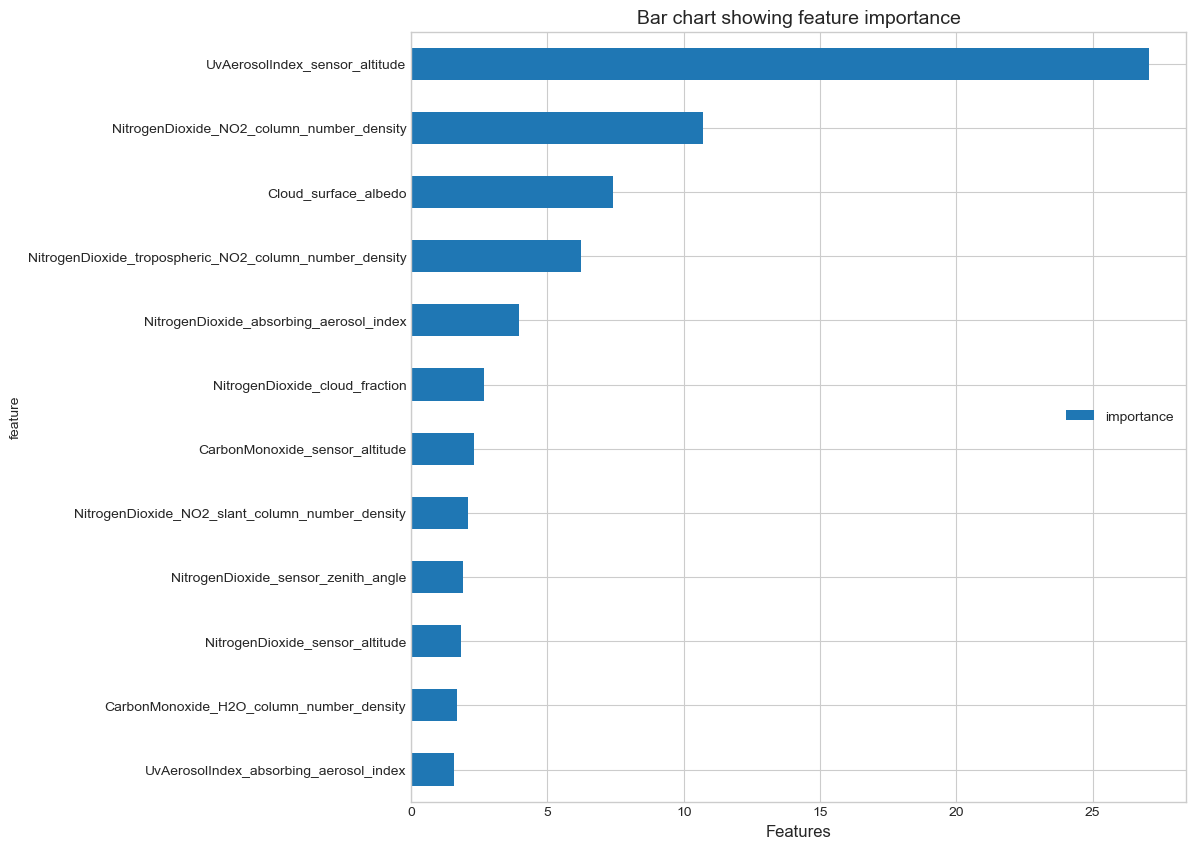

In [70]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [108]:
# Set up cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate ROC AUC
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error',cv=cv,error_score='raise')

Learning rate set to 0.078021
0:	learn: 2.2390178	total: 45.1ms	remaining: 45.1s
1:	learn: 2.1867504	total: 87.7ms	remaining: 43.8s
2:	learn: 2.1391289	total: 129ms	remaining: 43s
3:	learn: 2.0982314	total: 171ms	remaining: 42.5s
4:	learn: 2.0600082	total: 224ms	remaining: 44.6s
5:	learn: 2.0281959	total: 267ms	remaining: 44.3s
6:	learn: 2.0000853	total: 308ms	remaining: 43.7s
7:	learn: 1.9761408	total: 355ms	remaining: 44s
8:	learn: 1.9561491	total: 400ms	remaining: 44s
9:	learn: 1.9366174	total: 446ms	remaining: 44.2s
10:	learn: 1.9200614	total: 516ms	remaining: 46.3s
11:	learn: 1.9037429	total: 562ms	remaining: 46.2s
12:	learn: 1.8908538	total: 607ms	remaining: 46.1s
13:	learn: 1.8787094	total: 668ms	remaining: 47.1s
14:	learn: 1.8676639	total: 736ms	remaining: 48.3s
15:	learn: 1.8571191	total: 781ms	remaining: 48s
16:	learn: 1.8489170	total: 823ms	remaining: 47.6s
17:	learn: 1.8417568	total: 867ms	remaining: 47.3s
18:	learn: 1.8345911	total: 923ms	remaining: 47.7s
19:	learn: 1.8286

164:	learn: 1.6533191	total: 7.83s	remaining: 39.6s
165:	learn: 1.6526928	total: 7.87s	remaining: 39.5s
166:	learn: 1.6520825	total: 7.91s	remaining: 39.5s
167:	learn: 1.6509955	total: 7.96s	remaining: 39.4s
168:	learn: 1.6504319	total: 8s	remaining: 39.3s
169:	learn: 1.6499146	total: 8.04s	remaining: 39.2s
170:	learn: 1.6492082	total: 8.08s	remaining: 39.2s
171:	learn: 1.6484872	total: 8.12s	remaining: 39.1s
172:	learn: 1.6478966	total: 8.16s	remaining: 39s
173:	learn: 1.6472240	total: 8.2s	remaining: 38.9s
174:	learn: 1.6465331	total: 8.25s	remaining: 38.9s
175:	learn: 1.6457638	total: 8.3s	remaining: 38.9s
176:	learn: 1.6452154	total: 8.34s	remaining: 38.8s
177:	learn: 1.6446654	total: 8.38s	remaining: 38.7s
178:	learn: 1.6439850	total: 8.43s	remaining: 38.7s
179:	learn: 1.6434826	total: 8.47s	remaining: 38.6s
180:	learn: 1.6429702	total: 8.51s	remaining: 38.5s
181:	learn: 1.6424648	total: 8.56s	remaining: 38.5s
182:	learn: 1.6418563	total: 8.6s	remaining: 38.4s
183:	learn: 1.641443

327:	learn: 1.5738460	total: 15.4s	remaining: 31.6s
328:	learn: 1.5733094	total: 15.5s	remaining: 31.6s
329:	learn: 1.5730017	total: 15.5s	remaining: 31.5s
330:	learn: 1.5727360	total: 15.6s	remaining: 31.5s
331:	learn: 1.5723011	total: 15.6s	remaining: 31.4s
332:	learn: 1.5719167	total: 15.7s	remaining: 31.4s
333:	learn: 1.5715457	total: 15.7s	remaining: 31.3s
334:	learn: 1.5711792	total: 15.7s	remaining: 31.2s
335:	learn: 1.5707559	total: 15.8s	remaining: 31.2s
336:	learn: 1.5703066	total: 15.8s	remaining: 31.2s
337:	learn: 1.5699574	total: 15.9s	remaining: 31.1s
338:	learn: 1.5696546	total: 15.9s	remaining: 31s
339:	learn: 1.5693458	total: 16s	remaining: 31s
340:	learn: 1.5689570	total: 16s	remaining: 30.9s
341:	learn: 1.5686659	total: 16.1s	remaining: 30.9s
342:	learn: 1.5681149	total: 16.1s	remaining: 30.8s
343:	learn: 1.5678192	total: 16.2s	remaining: 30.8s
344:	learn: 1.5675064	total: 16.2s	remaining: 30.8s
345:	learn: 1.5672449	total: 16.3s	remaining: 30.7s
346:	learn: 1.566940

486:	learn: 1.5210363	total: 22.5s	remaining: 23.7s
487:	learn: 1.5207220	total: 22.6s	remaining: 23.7s
488:	learn: 1.5204604	total: 22.6s	remaining: 23.6s
489:	learn: 1.5201607	total: 22.6s	remaining: 23.6s
490:	learn: 1.5197839	total: 22.7s	remaining: 23.5s
491:	learn: 1.5196298	total: 22.7s	remaining: 23.5s
492:	learn: 1.5192873	total: 22.8s	remaining: 23.4s
493:	learn: 1.5189639	total: 22.8s	remaining: 23.4s
494:	learn: 1.5187608	total: 22.8s	remaining: 23.3s
495:	learn: 1.5183803	total: 22.9s	remaining: 23.3s
496:	learn: 1.5181054	total: 22.9s	remaining: 23.2s
497:	learn: 1.5177882	total: 23s	remaining: 23.2s
498:	learn: 1.5174031	total: 23s	remaining: 23.1s
499:	learn: 1.5171894	total: 23.1s	remaining: 23.1s
500:	learn: 1.5169122	total: 23.1s	remaining: 23s
501:	learn: 1.5166308	total: 23.1s	remaining: 23s
502:	learn: 1.5162021	total: 23.2s	remaining: 22.9s
503:	learn: 1.5159246	total: 23.2s	remaining: 22.8s
504:	learn: 1.5154443	total: 23.3s	remaining: 22.8s
505:	learn: 1.515158

646:	learn: 1.4781159	total: 30.8s	remaining: 16.8s
647:	learn: 1.4779298	total: 30.8s	remaining: 16.8s
648:	learn: 1.4776266	total: 30.9s	remaining: 16.7s
649:	learn: 1.4772642	total: 30.9s	remaining: 16.7s
650:	learn: 1.4770251	total: 31s	remaining: 16.6s
651:	learn: 1.4767500	total: 31s	remaining: 16.6s
652:	learn: 1.4765567	total: 31.1s	remaining: 16.5s
653:	learn: 1.4763378	total: 31.1s	remaining: 16.5s
654:	learn: 1.4761101	total: 31.2s	remaining: 16.4s
655:	learn: 1.4757426	total: 31.2s	remaining: 16.4s
656:	learn: 1.4754191	total: 31.3s	remaining: 16.3s
657:	learn: 1.4751381	total: 31.3s	remaining: 16.3s
658:	learn: 1.4749790	total: 31.4s	remaining: 16.2s
659:	learn: 1.4747583	total: 31.4s	remaining: 16.2s
660:	learn: 1.4744849	total: 31.5s	remaining: 16.1s
661:	learn: 1.4742707	total: 31.5s	remaining: 16.1s
662:	learn: 1.4740447	total: 31.6s	remaining: 16s
663:	learn: 1.4737617	total: 31.6s	remaining: 16s
664:	learn: 1.4735158	total: 31.7s	remaining: 15.9s
665:	learn: 1.473270

807:	learn: 1.4399869	total: 41.2s	remaining: 9.79s
808:	learn: 1.4397609	total: 41.3s	remaining: 9.74s
809:	learn: 1.4396042	total: 41.3s	remaining: 9.69s
810:	learn: 1.4393725	total: 41.4s	remaining: 9.64s
811:	learn: 1.4392465	total: 41.4s	remaining: 9.59s
812:	learn: 1.4390408	total: 41.5s	remaining: 9.54s
813:	learn: 1.4388567	total: 41.5s	remaining: 9.48s
814:	learn: 1.4385469	total: 41.6s	remaining: 9.44s
815:	learn: 1.4383333	total: 41.7s	remaining: 9.4s
816:	learn: 1.4381435	total: 41.8s	remaining: 9.36s
817:	learn: 1.4378805	total: 41.9s	remaining: 9.31s
818:	learn: 1.4376368	total: 41.9s	remaining: 9.27s
819:	learn: 1.4374480	total: 42s	remaining: 9.22s
820:	learn: 1.4371903	total: 42s	remaining: 9.17s
821:	learn: 1.4370075	total: 42.1s	remaining: 9.12s
822:	learn: 1.4367993	total: 42.1s	remaining: 9.06s
823:	learn: 1.4366655	total: 42.2s	remaining: 9.01s
824:	learn: 1.4364901	total: 42.3s	remaining: 8.97s
825:	learn: 1.4362631	total: 42.3s	remaining: 8.92s
826:	learn: 1.435

967:	learn: 1.4073202	total: 49.8s	remaining: 1.65s
968:	learn: 1.4071467	total: 49.8s	remaining: 1.59s
969:	learn: 1.4069123	total: 49.9s	remaining: 1.54s
970:	learn: 1.4065899	total: 49.9s	remaining: 1.49s
971:	learn: 1.4064348	total: 50s	remaining: 1.44s
972:	learn: 1.4061634	total: 50.1s	remaining: 1.39s
973:	learn: 1.4059135	total: 50.2s	remaining: 1.34s
974:	learn: 1.4057952	total: 50.3s	remaining: 1.29s
975:	learn: 1.4056359	total: 50.3s	remaining: 1.24s
976:	learn: 1.4054140	total: 50.4s	remaining: 1.19s
977:	learn: 1.4052734	total: 50.4s	remaining: 1.13s
978:	learn: 1.4050612	total: 50.5s	remaining: 1.08s
979:	learn: 1.4048904	total: 50.5s	remaining: 1.03s
980:	learn: 1.4047051	total: 50.6s	remaining: 979ms
981:	learn: 1.4044840	total: 50.6s	remaining: 928ms
982:	learn: 1.4043418	total: 50.7s	remaining: 876ms
983:	learn: 1.4041487	total: 50.7s	remaining: 824ms
984:	learn: 1.4039078	total: 50.8s	remaining: 773ms
985:	learn: 1.4037036	total: 50.8s	remaining: 721ms
986:	learn: 1.

129:	learn: 1.6807795	total: 6.21s	remaining: 41.5s
130:	learn: 1.6801358	total: 6.25s	remaining: 41.5s
131:	learn: 1.6796913	total: 6.31s	remaining: 41.5s
132:	learn: 1.6787440	total: 6.35s	remaining: 41.4s
133:	learn: 1.6781919	total: 6.4s	remaining: 41.4s
134:	learn: 1.6775133	total: 6.45s	remaining: 41.4s
135:	learn: 1.6770111	total: 6.5s	remaining: 41.3s
136:	learn: 1.6763063	total: 6.55s	remaining: 41.3s
137:	learn: 1.6757973	total: 6.58s	remaining: 41.1s
138:	learn: 1.6750619	total: 6.63s	remaining: 41.1s
139:	learn: 1.6742213	total: 6.67s	remaining: 41s
140:	learn: 1.6734401	total: 6.71s	remaining: 40.9s
141:	learn: 1.6728978	total: 6.75s	remaining: 40.8s
142:	learn: 1.6723844	total: 6.79s	remaining: 40.7s
143:	learn: 1.6716999	total: 6.83s	remaining: 40.6s
144:	learn: 1.6710814	total: 6.87s	remaining: 40.5s
145:	learn: 1.6704226	total: 6.93s	remaining: 40.5s
146:	learn: 1.6697396	total: 6.97s	remaining: 40.4s
147:	learn: 1.6691600	total: 7.01s	remaining: 40.3s
148:	learn: 1.66

288:	learn: 1.5947027	total: 13.1s	remaining: 32.2s
289:	learn: 1.5943057	total: 13.1s	remaining: 32.1s
290:	learn: 1.5940264	total: 13.1s	remaining: 32s
291:	learn: 1.5937282	total: 13.2s	remaining: 32s
292:	learn: 1.5932247	total: 13.2s	remaining: 31.9s
293:	learn: 1.5926096	total: 13.3s	remaining: 31.9s
294:	learn: 1.5920253	total: 13.3s	remaining: 31.8s
295:	learn: 1.5916767	total: 13.3s	remaining: 31.7s
296:	learn: 1.5913134	total: 13.4s	remaining: 31.7s
297:	learn: 1.5908913	total: 13.4s	remaining: 31.6s
298:	learn: 1.5904278	total: 13.5s	remaining: 31.6s
299:	learn: 1.5899671	total: 13.5s	remaining: 31.5s
300:	learn: 1.5895267	total: 13.6s	remaining: 31.5s
301:	learn: 1.5892140	total: 13.6s	remaining: 31.4s
302:	learn: 1.5889870	total: 13.6s	remaining: 31.4s
303:	learn: 1.5886046	total: 13.7s	remaining: 31.3s
304:	learn: 1.5881353	total: 13.7s	remaining: 31.3s
305:	learn: 1.5877514	total: 13.8s	remaining: 31.2s
306:	learn: 1.5872812	total: 13.8s	remaining: 31.2s
307:	learn: 1.58

448:	learn: 1.5384052	total: 21.3s	remaining: 26.1s
449:	learn: 1.5381035	total: 21.3s	remaining: 26s
450:	learn: 1.5378100	total: 21.3s	remaining: 26s
451:	learn: 1.5375402	total: 21.4s	remaining: 25.9s
452:	learn: 1.5372771	total: 21.4s	remaining: 25.9s
453:	learn: 1.5370306	total: 21.5s	remaining: 25.9s
454:	learn: 1.5366668	total: 21.6s	remaining: 25.9s
455:	learn: 1.5363782	total: 21.7s	remaining: 25.8s
456:	learn: 1.5360542	total: 21.7s	remaining: 25.8s
457:	learn: 1.5356705	total: 21.7s	remaining: 25.7s
458:	learn: 1.5353098	total: 21.8s	remaining: 25.7s
459:	learn: 1.5349741	total: 21.8s	remaining: 25.6s
460:	learn: 1.5347201	total: 21.9s	remaining: 25.6s
461:	learn: 1.5344611	total: 21.9s	remaining: 25.5s
462:	learn: 1.5341795	total: 21.9s	remaining: 25.4s
463:	learn: 1.5338846	total: 22s	remaining: 25.4s
464:	learn: 1.5335183	total: 22s	remaining: 25.3s
465:	learn: 1.5331895	total: 22.1s	remaining: 25.3s
466:	learn: 1.5329333	total: 22.1s	remaining: 25.2s
467:	learn: 1.532665

611:	learn: 1.4910681	total: 28.8s	remaining: 18.3s
612:	learn: 1.4907653	total: 28.9s	remaining: 18.2s
613:	learn: 1.4905932	total: 28.9s	remaining: 18.2s
614:	learn: 1.4903881	total: 29s	remaining: 18.1s
615:	learn: 1.4901286	total: 29s	remaining: 18.1s
616:	learn: 1.4897949	total: 29s	remaining: 18s
617:	learn: 1.4894101	total: 29.1s	remaining: 18s
618:	learn: 1.4891212	total: 29.2s	remaining: 17.9s
619:	learn: 1.4889276	total: 29.2s	remaining: 17.9s
620:	learn: 1.4885359	total: 29.2s	remaining: 17.9s
621:	learn: 1.4883066	total: 29.3s	remaining: 17.8s
622:	learn: 1.4880575	total: 29.3s	remaining: 17.7s
623:	learn: 1.4878018	total: 29.4s	remaining: 17.7s
624:	learn: 1.4876026	total: 29.4s	remaining: 17.6s
625:	learn: 1.4872888	total: 29.4s	remaining: 17.6s
626:	learn: 1.4871025	total: 29.5s	remaining: 17.5s
627:	learn: 1.4867752	total: 29.6s	remaining: 17.5s
628:	learn: 1.4864523	total: 29.7s	remaining: 17.5s
629:	learn: 1.4862518	total: 29.7s	remaining: 17.5s
630:	learn: 1.4859705	

770:	learn: 1.4525256	total: 36.5s	remaining: 10.9s
771:	learn: 1.4523611	total: 36.6s	remaining: 10.8s
772:	learn: 1.4521327	total: 36.6s	remaining: 10.8s
773:	learn: 1.4519176	total: 36.7s	remaining: 10.7s
774:	learn: 1.4517074	total: 36.7s	remaining: 10.7s
775:	learn: 1.4513680	total: 36.7s	remaining: 10.6s
776:	learn: 1.4510897	total: 36.8s	remaining: 10.6s
777:	learn: 1.4507978	total: 36.8s	remaining: 10.5s
778:	learn: 1.4506093	total: 36.9s	remaining: 10.5s
779:	learn: 1.4503992	total: 36.9s	remaining: 10.4s
780:	learn: 1.4502478	total: 37s	remaining: 10.4s
781:	learn: 1.4500786	total: 37s	remaining: 10.3s
782:	learn: 1.4499202	total: 37s	remaining: 10.3s
783:	learn: 1.4496989	total: 37.1s	remaining: 10.2s
784:	learn: 1.4494589	total: 37.1s	remaining: 10.2s
785:	learn: 1.4492270	total: 37.2s	remaining: 10.1s
786:	learn: 1.4489636	total: 37.2s	remaining: 10.1s
787:	learn: 1.4487005	total: 37.2s	remaining: 10s
788:	learn: 1.4485050	total: 37.3s	remaining: 9.97s
789:	learn: 1.448302

934:	learn: 1.4167373	total: 43.9s	remaining: 3.05s
935:	learn: 1.4166015	total: 44s	remaining: 3.01s
936:	learn: 1.4163833	total: 44s	remaining: 2.96s
937:	learn: 1.4162202	total: 44.1s	remaining: 2.91s
938:	learn: 1.4159931	total: 44.1s	remaining: 2.86s
939:	learn: 1.4158119	total: 44.1s	remaining: 2.82s
940:	learn: 1.4157090	total: 44.2s	remaining: 2.77s
941:	learn: 1.4154564	total: 44.2s	remaining: 2.72s
942:	learn: 1.4152679	total: 44.3s	remaining: 2.67s
943:	learn: 1.4151733	total: 44.3s	remaining: 2.63s
944:	learn: 1.4149502	total: 44.4s	remaining: 2.58s
945:	learn: 1.4148199	total: 44.4s	remaining: 2.54s
946:	learn: 1.4146248	total: 44.5s	remaining: 2.49s
947:	learn: 1.4143899	total: 44.6s	remaining: 2.44s
948:	learn: 1.4141559	total: 44.6s	remaining: 2.4s
949:	learn: 1.4138682	total: 44.7s	remaining: 2.35s
950:	learn: 1.4136177	total: 44.8s	remaining: 2.31s
951:	learn: 1.4134574	total: 44.8s	remaining: 2.26s
952:	learn: 1.4132732	total: 44.8s	remaining: 2.21s
953:	learn: 1.413

98:	learn: 1.6965991	total: 4.32s	remaining: 39.3s
99:	learn: 1.6956843	total: 4.36s	remaining: 39.3s
100:	learn: 1.6953018	total: 4.4s	remaining: 39.2s
101:	learn: 1.6945306	total: 4.44s	remaining: 39.1s
102:	learn: 1.6935632	total: 4.49s	remaining: 39.1s
103:	learn: 1.6930819	total: 4.53s	remaining: 39s
104:	learn: 1.6920539	total: 4.57s	remaining: 39s
105:	learn: 1.6917290	total: 4.61s	remaining: 38.9s
106:	learn: 1.6912127	total: 4.65s	remaining: 38.8s
107:	learn: 1.6903737	total: 4.69s	remaining: 38.8s
108:	learn: 1.6896533	total: 4.74s	remaining: 38.7s
109:	learn: 1.6890409	total: 4.78s	remaining: 38.7s
110:	learn: 1.6884943	total: 4.83s	remaining: 38.7s
111:	learn: 1.6880516	total: 4.87s	remaining: 38.6s
112:	learn: 1.6873146	total: 4.91s	remaining: 38.5s
113:	learn: 1.6867114	total: 4.95s	remaining: 38.5s
114:	learn: 1.6859367	total: 4.99s	remaining: 38.4s
115:	learn: 1.6854741	total: 5.03s	remaining: 38.3s
116:	learn: 1.6843513	total: 5.08s	remaining: 38.3s
117:	learn: 1.68323

260:	learn: 1.6012791	total: 11s	remaining: 31.1s
261:	learn: 1.6006801	total: 11s	remaining: 31s
262:	learn: 1.6003834	total: 11.1s	remaining: 31s
263:	learn: 1.5996658	total: 11.1s	remaining: 30.9s
264:	learn: 1.5993299	total: 11.1s	remaining: 30.9s
265:	learn: 1.5989219	total: 11.2s	remaining: 30.8s
266:	learn: 1.5983838	total: 11.2s	remaining: 30.8s
267:	learn: 1.5978896	total: 11.3s	remaining: 30.8s
268:	learn: 1.5969866	total: 11.3s	remaining: 30.7s
269:	learn: 1.5964686	total: 11.3s	remaining: 30.7s
270:	learn: 1.5960552	total: 11.4s	remaining: 30.6s
271:	learn: 1.5955349	total: 11.4s	remaining: 30.6s
272:	learn: 1.5950217	total: 11.5s	remaining: 30.5s
273:	learn: 1.5946915	total: 11.5s	remaining: 30.5s
274:	learn: 1.5941922	total: 11.5s	remaining: 30.4s
275:	learn: 1.5936348	total: 11.6s	remaining: 30.4s
276:	learn: 1.5931758	total: 11.6s	remaining: 30.3s
277:	learn: 1.5926261	total: 11.7s	remaining: 30.3s
278:	learn: 1.5922002	total: 11.7s	remaining: 30.2s
279:	learn: 1.591801

419:	learn: 1.5406469	total: 17.6s	remaining: 24.3s
420:	learn: 1.5402742	total: 17.6s	remaining: 24.2s
421:	learn: 1.5400277	total: 17.7s	remaining: 24.2s
422:	learn: 1.5397102	total: 17.7s	remaining: 24.2s
423:	learn: 1.5394108	total: 17.7s	remaining: 24.1s
424:	learn: 1.5391461	total: 17.8s	remaining: 24.1s
425:	learn: 1.5388699	total: 17.8s	remaining: 24s
426:	learn: 1.5384563	total: 17.9s	remaining: 24s
427:	learn: 1.5381050	total: 17.9s	remaining: 23.9s
428:	learn: 1.5378082	total: 17.9s	remaining: 23.9s
429:	learn: 1.5373685	total: 18s	remaining: 23.8s
430:	learn: 1.5370268	total: 18s	remaining: 23.8s
431:	learn: 1.5366180	total: 18.1s	remaining: 23.8s
432:	learn: 1.5362835	total: 18.1s	remaining: 23.7s
433:	learn: 1.5359561	total: 18.2s	remaining: 23.7s
434:	learn: 1.5355777	total: 18.2s	remaining: 23.6s
435:	learn: 1.5353374	total: 18.2s	remaining: 23.6s
436:	learn: 1.5351088	total: 18.3s	remaining: 23.5s
437:	learn: 1.5348836	total: 18.3s	remaining: 23.5s
438:	learn: 1.534601

578:	learn: 1.4937832	total: 24.7s	remaining: 17.9s
579:	learn: 1.4935385	total: 24.7s	remaining: 17.9s
580:	learn: 1.4930394	total: 24.7s	remaining: 17.8s
581:	learn: 1.4927389	total: 24.8s	remaining: 17.8s
582:	learn: 1.4924725	total: 24.8s	remaining: 17.8s
583:	learn: 1.4921284	total: 24.9s	remaining: 17.7s
584:	learn: 1.4918789	total: 24.9s	remaining: 17.7s
585:	learn: 1.4916226	total: 25s	remaining: 17.6s
586:	learn: 1.4913595	total: 25s	remaining: 17.6s
587:	learn: 1.4910657	total: 25.1s	remaining: 17.6s
588:	learn: 1.4908336	total: 25.1s	remaining: 17.5s
589:	learn: 1.4905735	total: 25.1s	remaining: 17.5s
590:	learn: 1.4902940	total: 25.2s	remaining: 17.4s
591:	learn: 1.4900215	total: 25.2s	remaining: 17.4s
592:	learn: 1.4898237	total: 25.3s	remaining: 17.3s
593:	learn: 1.4895538	total: 25.3s	remaining: 17.3s
594:	learn: 1.4891646	total: 25.4s	remaining: 17.3s
595:	learn: 1.4889223	total: 25.4s	remaining: 17.2s
596:	learn: 1.4887161	total: 25.4s	remaining: 17.2s
597:	learn: 1.48

739:	learn: 1.4533531	total: 31.5s	remaining: 11.1s
740:	learn: 1.4532479	total: 31.5s	remaining: 11s
741:	learn: 1.4529904	total: 31.6s	remaining: 11s
742:	learn: 1.4528084	total: 31.6s	remaining: 10.9s
743:	learn: 1.4526398	total: 31.7s	remaining: 10.9s
744:	learn: 1.4524021	total: 31.7s	remaining: 10.8s
745:	learn: 1.4522136	total: 31.7s	remaining: 10.8s
746:	learn: 1.4520874	total: 31.8s	remaining: 10.8s
747:	learn: 1.4518175	total: 31.8s	remaining: 10.7s
748:	learn: 1.4516006	total: 31.9s	remaining: 10.7s
749:	learn: 1.4513107	total: 31.9s	remaining: 10.6s
750:	learn: 1.4511180	total: 31.9s	remaining: 10.6s
751:	learn: 1.4508690	total: 32s	remaining: 10.5s
752:	learn: 1.4506375	total: 32s	remaining: 10.5s
753:	learn: 1.4503745	total: 32.1s	remaining: 10.5s
754:	learn: 1.4501325	total: 32.1s	remaining: 10.4s
755:	learn: 1.4498117	total: 32.1s	remaining: 10.4s
756:	learn: 1.4495981	total: 32.2s	remaining: 10.3s
757:	learn: 1.4493959	total: 32.2s	remaining: 10.3s
758:	learn: 1.449105

899:	learn: 1.4195183	total: 38s	remaining: 4.22s
900:	learn: 1.4192771	total: 38s	remaining: 4.18s
901:	learn: 1.4190109	total: 38.1s	remaining: 4.14s
902:	learn: 1.4189110	total: 38.1s	remaining: 4.09s
903:	learn: 1.4187189	total: 38.2s	remaining: 4.05s
904:	learn: 1.4184583	total: 38.2s	remaining: 4.01s
905:	learn: 1.4182066	total: 38.2s	remaining: 3.97s
906:	learn: 1.4179139	total: 38.3s	remaining: 3.92s
907:	learn: 1.4175703	total: 38.3s	remaining: 3.88s
908:	learn: 1.4173419	total: 38.4s	remaining: 3.84s
909:	learn: 1.4171598	total: 38.4s	remaining: 3.8s
910:	learn: 1.4169604	total: 38.4s	remaining: 3.76s
911:	learn: 1.4167581	total: 38.5s	remaining: 3.71s
912:	learn: 1.4166044	total: 38.5s	remaining: 3.67s
913:	learn: 1.4163789	total: 38.6s	remaining: 3.63s
914:	learn: 1.4162307	total: 38.6s	remaining: 3.59s
915:	learn: 1.4160212	total: 38.7s	remaining: 3.54s
916:	learn: 1.4157313	total: 38.7s	remaining: 3.5s
917:	learn: 1.4154623	total: 38.7s	remaining: 3.46s
918:	learn: 1.4152

59:	learn: 1.7390790	total: 2.61s	remaining: 40.9s
60:	learn: 1.7381242	total: 2.65s	remaining: 40.9s
61:	learn: 1.7368215	total: 2.7s	remaining: 40.8s
62:	learn: 1.7355778	total: 2.74s	remaining: 40.7s
63:	learn: 1.7343946	total: 2.79s	remaining: 40.8s
64:	learn: 1.7331384	total: 2.85s	remaining: 41s
65:	learn: 1.7321388	total: 2.9s	remaining: 41.1s
66:	learn: 1.7314540	total: 2.94s	remaining: 41s
67:	learn: 1.7298288	total: 2.98s	remaining: 40.9s
68:	learn: 1.7291179	total: 3.03s	remaining: 40.9s
69:	learn: 1.7281068	total: 3.08s	remaining: 41s
70:	learn: 1.7263206	total: 3.14s	remaining: 41.1s
71:	learn: 1.7248262	total: 3.19s	remaining: 41.1s
72:	learn: 1.7233134	total: 3.23s	remaining: 41s
73:	learn: 1.7226419	total: 3.27s	remaining: 40.9s
74:	learn: 1.7211321	total: 3.31s	remaining: 40.8s
75:	learn: 1.7203466	total: 3.36s	remaining: 40.9s
76:	learn: 1.7196043	total: 3.42s	remaining: 40.9s
77:	learn: 1.7188879	total: 3.46s	remaining: 40.9s
78:	learn: 1.7178520	total: 3.51s	remaini

223:	learn: 1.6246819	total: 11.1s	remaining: 38.4s
224:	learn: 1.6242485	total: 11.1s	remaining: 38.3s
225:	learn: 1.6235227	total: 11.2s	remaining: 38.3s
226:	learn: 1.6228566	total: 11.2s	remaining: 38.2s
227:	learn: 1.6224326	total: 11.3s	remaining: 38.1s
228:	learn: 1.6219059	total: 11.3s	remaining: 38s
229:	learn: 1.6213121	total: 11.3s	remaining: 38s
230:	learn: 1.6209164	total: 11.4s	remaining: 37.9s
231:	learn: 1.6204459	total: 11.4s	remaining: 37.8s
232:	learn: 1.6198136	total: 11.5s	remaining: 37.8s
233:	learn: 1.6195016	total: 11.5s	remaining: 37.7s
234:	learn: 1.6191130	total: 11.6s	remaining: 37.6s
235:	learn: 1.6184922	total: 11.6s	remaining: 37.6s
236:	learn: 1.6177552	total: 11.7s	remaining: 37.5s
237:	learn: 1.6172075	total: 11.7s	remaining: 37.5s
238:	learn: 1.6167606	total: 11.8s	remaining: 37.4s
239:	learn: 1.6162629	total: 11.8s	remaining: 37.5s
240:	learn: 1.6158383	total: 11.9s	remaining: 37.4s
241:	learn: 1.6154026	total: 11.9s	remaining: 37.3s
242:	learn: 1.61

382:	learn: 1.5598834	total: 18s	remaining: 29s
383:	learn: 1.5595267	total: 18.1s	remaining: 29s
384:	learn: 1.5592590	total: 18.1s	remaining: 28.9s
385:	learn: 1.5589997	total: 18.1s	remaining: 28.8s
386:	learn: 1.5587297	total: 18.2s	remaining: 28.8s
387:	learn: 1.5584399	total: 18.2s	remaining: 28.7s
388:	learn: 1.5580665	total: 18.2s	remaining: 28.7s
389:	learn: 1.5576184	total: 18.3s	remaining: 28.6s
390:	learn: 1.5573036	total: 18.3s	remaining: 28.6s
391:	learn: 1.5570209	total: 18.4s	remaining: 28.5s
392:	learn: 1.5566243	total: 18.4s	remaining: 28.5s
393:	learn: 1.5563511	total: 18.5s	remaining: 28.4s
394:	learn: 1.5560735	total: 18.5s	remaining: 28.4s
395:	learn: 1.5556883	total: 18.6s	remaining: 28.3s
396:	learn: 1.5553325	total: 18.6s	remaining: 28.3s
397:	learn: 1.5549521	total: 18.7s	remaining: 28.2s
398:	learn: 1.5546036	total: 18.7s	remaining: 28.2s
399:	learn: 1.5542680	total: 18.7s	remaining: 28.1s
400:	learn: 1.5539565	total: 18.8s	remaining: 28.1s
401:	learn: 1.5535

544:	learn: 1.5111373	total: 24.8s	remaining: 20.7s
545:	learn: 1.5108618	total: 24.8s	remaining: 20.6s
546:	learn: 1.5106072	total: 24.9s	remaining: 20.6s
547:	learn: 1.5103798	total: 24.9s	remaining: 20.5s
548:	learn: 1.5100689	total: 24.9s	remaining: 20.5s
549:	learn: 1.5097728	total: 25s	remaining: 20.4s
550:	learn: 1.5094572	total: 25s	remaining: 20.4s
551:	learn: 1.5091998	total: 25.1s	remaining: 20.3s
552:	learn: 1.5088944	total: 25.1s	remaining: 20.3s
553:	learn: 1.5086487	total: 25.1s	remaining: 20.2s
554:	learn: 1.5084502	total: 25.2s	remaining: 20.2s
555:	learn: 1.5081781	total: 25.2s	remaining: 20.1s
556:	learn: 1.5078857	total: 25.3s	remaining: 20.1s
557:	learn: 1.5076549	total: 25.3s	remaining: 20s
558:	learn: 1.5074351	total: 25.3s	remaining: 20s
559:	learn: 1.5072805	total: 25.4s	remaining: 19.9s
560:	learn: 1.5071069	total: 25.4s	remaining: 19.9s
561:	learn: 1.5068830	total: 25.5s	remaining: 19.8s
562:	learn: 1.5066884	total: 25.5s	remaining: 19.8s
563:	learn: 1.506387

707:	learn: 1.4701646	total: 31.6s	remaining: 13s
708:	learn: 1.4698645	total: 31.6s	remaining: 13s
709:	learn: 1.4696608	total: 31.6s	remaining: 12.9s
710:	learn: 1.4694595	total: 31.7s	remaining: 12.9s
711:	learn: 1.4692795	total: 31.7s	remaining: 12.8s
712:	learn: 1.4690066	total: 31.8s	remaining: 12.8s
713:	learn: 1.4688430	total: 31.8s	remaining: 12.7s
714:	learn: 1.4684803	total: 31.8s	remaining: 12.7s
715:	learn: 1.4681959	total: 31.9s	remaining: 12.6s
716:	learn: 1.4679637	total: 31.9s	remaining: 12.6s
717:	learn: 1.4677661	total: 32s	remaining: 12.6s
718:	learn: 1.4675244	total: 32s	remaining: 12.5s
719:	learn: 1.4673115	total: 32s	remaining: 12.5s
720:	learn: 1.4670121	total: 32.1s	remaining: 12.4s
721:	learn: 1.4668121	total: 32.1s	remaining: 12.4s
722:	learn: 1.4665982	total: 32.2s	remaining: 12.3s
723:	learn: 1.4664651	total: 32.2s	remaining: 12.3s
724:	learn: 1.4662761	total: 32.3s	remaining: 12.2s
725:	learn: 1.4661468	total: 32.3s	remaining: 12.2s
726:	learn: 1.4658921	

867:	learn: 1.4348075	total: 38.3s	remaining: 5.83s
868:	learn: 1.4346095	total: 38.4s	remaining: 5.78s
869:	learn: 1.4344679	total: 38.4s	remaining: 5.74s
870:	learn: 1.4342648	total: 38.4s	remaining: 5.69s
871:	learn: 1.4340123	total: 38.5s	remaining: 5.65s
872:	learn: 1.4338654	total: 38.5s	remaining: 5.6s
873:	learn: 1.4336796	total: 38.6s	remaining: 5.56s
874:	learn: 1.4334750	total: 38.6s	remaining: 5.51s
875:	learn: 1.4332540	total: 38.6s	remaining: 5.47s
876:	learn: 1.4330358	total: 38.7s	remaining: 5.42s
877:	learn: 1.4328135	total: 38.7s	remaining: 5.38s
878:	learn: 1.4326482	total: 38.8s	remaining: 5.34s
879:	learn: 1.4324619	total: 38.8s	remaining: 5.29s
880:	learn: 1.4322508	total: 38.9s	remaining: 5.25s
881:	learn: 1.4320942	total: 38.9s	remaining: 5.2s
882:	learn: 1.4318467	total: 38.9s	remaining: 5.16s
883:	learn: 1.4317064	total: 39s	remaining: 5.11s
884:	learn: 1.4315375	total: 39s	remaining: 5.07s
885:	learn: 1.4313143	total: 39s	remaining: 5.02s
886:	learn: 1.431076

28:	learn: 1.7941455	total: 1.84s	remaining: 1m 1s
29:	learn: 1.7913156	total: 1.89s	remaining: 1m 1s
30:	learn: 1.7882860	total: 1.93s	remaining: 1m
31:	learn: 1.7850495	total: 1.98s	remaining: 59.8s
32:	learn: 1.7828669	total: 2.02s	remaining: 59.1s
33:	learn: 1.7804921	total: 2.06s	remaining: 58.5s
34:	learn: 1.7789313	total: 2.12s	remaining: 58.4s
35:	learn: 1.7764320	total: 2.17s	remaining: 58.2s
36:	learn: 1.7744346	total: 2.23s	remaining: 57.9s
37:	learn: 1.7725776	total: 2.27s	remaining: 57.4s
38:	learn: 1.7705790	total: 2.32s	remaining: 57.1s
39:	learn: 1.7678902	total: 2.36s	remaining: 56.6s
40:	learn: 1.7660793	total: 2.4s	remaining: 56.1s
41:	learn: 1.7648841	total: 2.43s	remaining: 55.5s
42:	learn: 1.7628105	total: 2.48s	remaining: 55.1s
43:	learn: 1.7613300	total: 2.52s	remaining: 54.8s
44:	learn: 1.7596026	total: 2.56s	remaining: 54.4s
45:	learn: 1.7577073	total: 2.61s	remaining: 54.1s
46:	learn: 1.7562575	total: 2.65s	remaining: 53.6s
47:	learn: 1.7551510	total: 2.69s	r

188:	learn: 1.6437081	total: 9.28s	remaining: 39.8s
189:	learn: 1.6431768	total: 9.32s	remaining: 39.7s
190:	learn: 1.6426767	total: 9.36s	remaining: 39.7s
191:	learn: 1.6422444	total: 9.4s	remaining: 39.6s
192:	learn: 1.6418420	total: 9.44s	remaining: 39.5s
193:	learn: 1.6408521	total: 9.49s	remaining: 39.4s
194:	learn: 1.6402000	total: 9.53s	remaining: 39.3s
195:	learn: 1.6397302	total: 9.57s	remaining: 39.2s
196:	learn: 1.6392726	total: 9.61s	remaining: 39.2s
197:	learn: 1.6388828	total: 9.65s	remaining: 39.1s
198:	learn: 1.6382952	total: 9.69s	remaining: 39s
199:	learn: 1.6377168	total: 9.73s	remaining: 38.9s
200:	learn: 1.6372888	total: 9.77s	remaining: 38.8s
201:	learn: 1.6366158	total: 9.82s	remaining: 38.8s
202:	learn: 1.6360884	total: 9.86s	remaining: 38.7s
203:	learn: 1.6351738	total: 9.91s	remaining: 38.7s
204:	learn: 1.6346180	total: 9.95s	remaining: 38.6s
205:	learn: 1.6337093	total: 9.99s	remaining: 38.5s
206:	learn: 1.6332269	total: 10s	remaining: 38.4s
207:	learn: 1.632

350:	learn: 1.5715559	total: 16.1s	remaining: 29.8s
351:	learn: 1.5710938	total: 16.1s	remaining: 29.7s
352:	learn: 1.5706526	total: 16.2s	remaining: 29.7s
353:	learn: 1.5703057	total: 16.2s	remaining: 29.6s
354:	learn: 1.5699887	total: 16.3s	remaining: 29.6s
355:	learn: 1.5697169	total: 16.3s	remaining: 29.5s
356:	learn: 1.5694428	total: 16.3s	remaining: 29.4s
357:	learn: 1.5691479	total: 16.4s	remaining: 29.4s
358:	learn: 1.5688690	total: 16.4s	remaining: 29.3s
359:	learn: 1.5685528	total: 16.5s	remaining: 29.3s
360:	learn: 1.5682103	total: 16.5s	remaining: 29.2s
361:	learn: 1.5678859	total: 16.5s	remaining: 29.2s
362:	learn: 1.5675775	total: 16.6s	remaining: 29.1s
363:	learn: 1.5673050	total: 16.6s	remaining: 29.1s
364:	learn: 1.5669378	total: 16.7s	remaining: 29s
365:	learn: 1.5664540	total: 16.7s	remaining: 28.9s
366:	learn: 1.5661269	total: 16.8s	remaining: 28.9s
367:	learn: 1.5657738	total: 16.8s	remaining: 28.8s
368:	learn: 1.5652318	total: 16.8s	remaining: 28.8s
369:	learn: 1.

512:	learn: 1.5188234	total: 23.4s	remaining: 22.2s
513:	learn: 1.5184805	total: 23.4s	remaining: 22.1s
514:	learn: 1.5181633	total: 23.5s	remaining: 22.1s
515:	learn: 1.5178944	total: 23.5s	remaining: 22s
516:	learn: 1.5175012	total: 23.5s	remaining: 22s
517:	learn: 1.5171956	total: 23.6s	remaining: 22s
518:	learn: 1.5169764	total: 23.7s	remaining: 21.9s
519:	learn: 1.5167299	total: 23.7s	remaining: 21.9s
520:	learn: 1.5164978	total: 23.7s	remaining: 21.8s
521:	learn: 1.5162626	total: 23.8s	remaining: 21.8s
522:	learn: 1.5159635	total: 23.8s	remaining: 21.7s
523:	learn: 1.5157194	total: 23.9s	remaining: 21.7s
524:	learn: 1.5154112	total: 23.9s	remaining: 21.7s
525:	learn: 1.5151084	total: 24s	remaining: 21.6s
526:	learn: 1.5148516	total: 24s	remaining: 21.6s
527:	learn: 1.5146945	total: 24.1s	remaining: 21.5s
528:	learn: 1.5144387	total: 24.1s	remaining: 21.5s
529:	learn: 1.5140475	total: 24.2s	remaining: 21.4s
530:	learn: 1.5135412	total: 24.2s	remaining: 21.4s
531:	learn: 1.5132971	

672:	learn: 1.4765922	total: 30.6s	remaining: 14.9s
673:	learn: 1.4763284	total: 30.7s	remaining: 14.8s
674:	learn: 1.4759937	total: 30.7s	remaining: 14.8s
675:	learn: 1.4758121	total: 30.7s	remaining: 14.7s
676:	learn: 1.4754648	total: 30.8s	remaining: 14.7s
677:	learn: 1.4752628	total: 30.8s	remaining: 14.6s
678:	learn: 1.4750590	total: 30.9s	remaining: 14.6s
679:	learn: 1.4748371	total: 30.9s	remaining: 14.5s
680:	learn: 1.4746455	total: 30.9s	remaining: 14.5s
681:	learn: 1.4743236	total: 31s	remaining: 14.4s
682:	learn: 1.4740766	total: 31s	remaining: 14.4s
683:	learn: 1.4738334	total: 31.1s	remaining: 14.4s
684:	learn: 1.4736482	total: 31.1s	remaining: 14.3s
685:	learn: 1.4733841	total: 31.2s	remaining: 14.3s
686:	learn: 1.4730962	total: 31.2s	remaining: 14.2s
687:	learn: 1.4728696	total: 31.3s	remaining: 14.2s
688:	learn: 1.4725633	total: 31.3s	remaining: 14.1s
689:	learn: 1.4722076	total: 31.4s	remaining: 14.1s
690:	learn: 1.4720125	total: 31.4s	remaining: 14.1s
691:	learn: 1.47

835:	learn: 1.4379770	total: 37.7s	remaining: 7.41s
836:	learn: 1.4377951	total: 37.8s	remaining: 7.36s
837:	learn: 1.4375789	total: 37.8s	remaining: 7.31s
838:	learn: 1.4372614	total: 37.9s	remaining: 7.27s
839:	learn: 1.4370312	total: 37.9s	remaining: 7.22s
840:	learn: 1.4368179	total: 38s	remaining: 7.18s
841:	learn: 1.4365465	total: 38s	remaining: 7.13s
842:	learn: 1.4363022	total: 38s	remaining: 7.08s
843:	learn: 1.4361034	total: 38.1s	remaining: 7.04s
844:	learn: 1.4359043	total: 38.1s	remaining: 6.99s
845:	learn: 1.4357118	total: 38.2s	remaining: 6.94s
846:	learn: 1.4355723	total: 38.2s	remaining: 6.9s
847:	learn: 1.4353609	total: 38.2s	remaining: 6.85s
848:	learn: 1.4350806	total: 38.3s	remaining: 6.81s
849:	learn: 1.4348436	total: 38.3s	remaining: 6.76s
850:	learn: 1.4345679	total: 38.4s	remaining: 6.71s
851:	learn: 1.4344187	total: 38.4s	remaining: 6.67s
852:	learn: 1.4342519	total: 38.4s	remaining: 6.62s
853:	learn: 1.4340808	total: 38.5s	remaining: 6.58s
854:	learn: 1.43389

995:	learn: 1.4052112	total: 44.4s	remaining: 178ms
996:	learn: 1.4049935	total: 44.4s	remaining: 134ms
997:	learn: 1.4048042	total: 44.5s	remaining: 89.1ms
998:	learn: 1.4045623	total: 44.5s	remaining: 44.6ms
999:	learn: 1.4043647	total: 44.6s	remaining: 0us


In [109]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error

r2_scorer = make_scorer(r2_score, greater_is_better=False)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

scores_r = cross_validate(model, X, y, scoring=r2_scorer, cv=5, return_train_score=True)
scores_mse = cross_validate(model, X, y, scoring=rmse_scorer, cv=5, return_train_score=True)

def score(scores):
    print("test_r2 score:", (-scores_r['test_score'].mean()))
    print("test_rmse score:",  (-scores_mse['test_score'].mean())**0.5)
score(scores)

Learning rate set to 0.078021
0:	learn: 2.3493443	total: 44.6ms	remaining: 44.6s
1:	learn: 2.2861722	total: 95.5ms	remaining: 47.7s
2:	learn: 2.2300575	total: 152ms	remaining: 50.7s
3:	learn: 2.1797183	total: 209ms	remaining: 52.1s
4:	learn: 2.1348394	total: 257ms	remaining: 51.2s
5:	learn: 2.0976710	total: 304ms	remaining: 50.3s
6:	learn: 2.0646437	total: 353ms	remaining: 50s
7:	learn: 2.0351038	total: 397ms	remaining: 49.2s
8:	learn: 2.0077654	total: 439ms	remaining: 48.4s
9:	learn: 1.9834828	total: 480ms	remaining: 47.5s
10:	learn: 1.9626471	total: 527ms	remaining: 47.4s
11:	learn: 1.9440028	total: 569ms	remaining: 46.9s
12:	learn: 1.9283114	total: 613ms	remaining: 46.6s
13:	learn: 1.9124961	total: 666ms	remaining: 46.9s
14:	learn: 1.9000804	total: 716ms	remaining: 47s
15:	learn: 1.8883465	total: 762ms	remaining: 46.9s
16:	learn: 1.8770385	total: 803ms	remaining: 46.4s
17:	learn: 1.8674860	total: 845ms	remaining: 46.1s
18:	learn: 1.8586240	total: 894ms	remaining: 46.2s
19:	learn: 1.

162:	learn: 1.6559437	total: 7.27s	remaining: 37.3s
163:	learn: 1.6554654	total: 7.31s	remaining: 37.3s
164:	learn: 1.6549725	total: 7.35s	remaining: 37.2s
165:	learn: 1.6543482	total: 7.39s	remaining: 37.1s
166:	learn: 1.6537664	total: 7.43s	remaining: 37s
167:	learn: 1.6529451	total: 7.47s	remaining: 37s
168:	learn: 1.6523675	total: 7.51s	remaining: 36.9s
169:	learn: 1.6517649	total: 7.55s	remaining: 36.9s
170:	learn: 1.6512015	total: 7.59s	remaining: 36.8s
171:	learn: 1.6507893	total: 7.63s	remaining: 36.7s
172:	learn: 1.6502290	total: 7.67s	remaining: 36.7s
173:	learn: 1.6496908	total: 7.71s	remaining: 36.6s
174:	learn: 1.6488560	total: 7.76s	remaining: 36.6s
175:	learn: 1.6480407	total: 7.8s	remaining: 36.5s
176:	learn: 1.6471844	total: 7.84s	remaining: 36.5s
177:	learn: 1.6466418	total: 7.88s	remaining: 36.4s
178:	learn: 1.6461192	total: 7.92s	remaining: 36.3s
179:	learn: 1.6456724	total: 7.96s	remaining: 36.3s
180:	learn: 1.6451996	total: 8s	remaining: 36.2s
181:	learn: 1.644644

324:	learn: 1.5738004	total: 14s	remaining: 29.1s
325:	learn: 1.5735320	total: 14.1s	remaining: 29.1s
326:	learn: 1.5731496	total: 14.1s	remaining: 29s
327:	learn: 1.5727470	total: 14.1s	remaining: 29s
328:	learn: 1.5724599	total: 14.2s	remaining: 28.9s
329:	learn: 1.5721958	total: 14.2s	remaining: 28.9s
330:	learn: 1.5718448	total: 14.3s	remaining: 28.8s
331:	learn: 1.5715161	total: 14.3s	remaining: 28.8s
332:	learn: 1.5712251	total: 14.3s	remaining: 28.7s
333:	learn: 1.5708921	total: 14.4s	remaining: 28.7s
334:	learn: 1.5705339	total: 14.4s	remaining: 28.6s
335:	learn: 1.5700341	total: 14.5s	remaining: 28.6s
336:	learn: 1.5697171	total: 14.5s	remaining: 28.5s
337:	learn: 1.5694013	total: 14.5s	remaining: 28.5s
338:	learn: 1.5690160	total: 14.6s	remaining: 28.5s
339:	learn: 1.5686826	total: 14.6s	remaining: 28.4s
340:	learn: 1.5682967	total: 14.7s	remaining: 28.4s
341:	learn: 1.5680281	total: 14.7s	remaining: 28.3s
342:	learn: 1.5675528	total: 14.8s	remaining: 28.3s
343:	learn: 1.5671

484:	learn: 1.5194463	total: 21.2s	remaining: 22.5s
485:	learn: 1.5192442	total: 21.2s	remaining: 22.4s
486:	learn: 1.5188783	total: 21.3s	remaining: 22.4s
487:	learn: 1.5185408	total: 21.3s	remaining: 22.4s
488:	learn: 1.5181582	total: 21.4s	remaining: 22.3s
489:	learn: 1.5177198	total: 21.5s	remaining: 22.3s
490:	learn: 1.5174868	total: 21.5s	remaining: 22.3s
491:	learn: 1.5172490	total: 21.6s	remaining: 22.3s
492:	learn: 1.5169810	total: 21.7s	remaining: 22.3s
493:	learn: 1.5166297	total: 21.7s	remaining: 22.2s
494:	learn: 1.5164280	total: 21.8s	remaining: 22.2s
495:	learn: 1.5162285	total: 21.8s	remaining: 22.2s
496:	learn: 1.5158258	total: 21.9s	remaining: 22.1s
497:	learn: 1.5156555	total: 21.9s	remaining: 22.1s
498:	learn: 1.5153296	total: 22s	remaining: 22.1s
499:	learn: 1.5149617	total: 22.1s	remaining: 22.1s
500:	learn: 1.5146894	total: 22.2s	remaining: 22.1s
501:	learn: 1.5143433	total: 22.2s	remaining: 22s
502:	learn: 1.5141245	total: 22.3s	remaining: 22s
503:	learn: 1.5138

644:	learn: 1.4753331	total: 29.6s	remaining: 16.3s
645:	learn: 1.4750917	total: 29.7s	remaining: 16.3s
646:	learn: 1.4747999	total: 29.8s	remaining: 16.2s
647:	learn: 1.4745777	total: 29.8s	remaining: 16.2s
648:	learn: 1.4742825	total: 29.9s	remaining: 16.2s
649:	learn: 1.4740538	total: 29.9s	remaining: 16.1s
650:	learn: 1.4737993	total: 30s	remaining: 16.1s
651:	learn: 1.4736009	total: 30s	remaining: 16s
652:	learn: 1.4733230	total: 30s	remaining: 16s
653:	learn: 1.4729647	total: 30.1s	remaining: 15.9s
654:	learn: 1.4727008	total: 30.1s	remaining: 15.9s
655:	learn: 1.4724050	total: 30.2s	remaining: 15.8s
656:	learn: 1.4721983	total: 30.2s	remaining: 15.8s
657:	learn: 1.4719259	total: 30.3s	remaining: 15.7s
658:	learn: 1.4715977	total: 30.3s	remaining: 15.7s
659:	learn: 1.4713357	total: 30.4s	remaining: 15.6s
660:	learn: 1.4711383	total: 30.4s	remaining: 15.6s
661:	learn: 1.4708538	total: 30.5s	remaining: 15.6s
662:	learn: 1.4706194	total: 30.5s	remaining: 15.5s
663:	learn: 1.4703025	

808:	learn: 1.4356540	total: 38.4s	remaining: 9.08s
809:	learn: 1.4354160	total: 38.5s	remaining: 9.03s
810:	learn: 1.4351503	total: 38.5s	remaining: 8.98s
811:	learn: 1.4348587	total: 38.6s	remaining: 8.93s
812:	learn: 1.4347109	total: 38.6s	remaining: 8.88s
813:	learn: 1.4344435	total: 38.7s	remaining: 8.83s
814:	learn: 1.4342760	total: 38.7s	remaining: 8.79s
815:	learn: 1.4341003	total: 38.7s	remaining: 8.74s
816:	learn: 1.4338965	total: 38.8s	remaining: 8.69s
817:	learn: 1.4337862	total: 38.8s	remaining: 8.64s
818:	learn: 1.4335418	total: 38.9s	remaining: 8.59s
819:	learn: 1.4333497	total: 38.9s	remaining: 8.54s
820:	learn: 1.4330457	total: 38.9s	remaining: 8.49s
821:	learn: 1.4327866	total: 39s	remaining: 8.44s
822:	learn: 1.4325585	total: 39s	remaining: 8.39s
823:	learn: 1.4323574	total: 39.1s	remaining: 8.35s
824:	learn: 1.4321895	total: 39.1s	remaining: 8.3s
825:	learn: 1.4319447	total: 39.2s	remaining: 8.25s
826:	learn: 1.4317511	total: 39.2s	remaining: 8.2s
827:	learn: 1.4314

968:	learn: 1.4007742	total: 45.4s	remaining: 1.45s
969:	learn: 1.4005575	total: 45.4s	remaining: 1.4s
970:	learn: 1.4003099	total: 45.5s	remaining: 1.36s
971:	learn: 1.4001456	total: 45.5s	remaining: 1.31s
972:	learn: 1.3999668	total: 45.5s	remaining: 1.26s
973:	learn: 1.3997749	total: 45.6s	remaining: 1.22s
974:	learn: 1.3995484	total: 45.6s	remaining: 1.17s
975:	learn: 1.3994367	total: 45.7s	remaining: 1.12s
976:	learn: 1.3992997	total: 45.7s	remaining: 1.08s
977:	learn: 1.3991591	total: 45.8s	remaining: 1.03s
978:	learn: 1.3988750	total: 45.8s	remaining: 983ms
979:	learn: 1.3986984	total: 45.9s	remaining: 936ms
980:	learn: 1.3984975	total: 45.9s	remaining: 889ms
981:	learn: 1.3982675	total: 45.9s	remaining: 842ms
982:	learn: 1.3980283	total: 46s	remaining: 795ms
983:	learn: 1.3977937	total: 46s	remaining: 748ms
984:	learn: 1.3975491	total: 46.1s	remaining: 702ms
985:	learn: 1.3973487	total: 46.1s	remaining: 655ms
986:	learn: 1.3971164	total: 46.2s	remaining: 608ms
987:	learn: 1.396

129:	learn: 1.6284476	total: 6.08s	remaining: 40.7s
130:	learn: 1.6278006	total: 6.12s	remaining: 40.6s
131:	learn: 1.6271955	total: 6.16s	remaining: 40.5s
132:	learn: 1.6267968	total: 6.19s	remaining: 40.4s
133:	learn: 1.6261659	total: 6.23s	remaining: 40.3s
134:	learn: 1.6256641	total: 6.28s	remaining: 40.2s
135:	learn: 1.6251352	total: 6.33s	remaining: 40.2s
136:	learn: 1.6243866	total: 6.37s	remaining: 40.1s
137:	learn: 1.6239510	total: 6.41s	remaining: 40s
138:	learn: 1.6232128	total: 6.46s	remaining: 40s
139:	learn: 1.6227265	total: 6.5s	remaining: 39.9s
140:	learn: 1.6221490	total: 6.54s	remaining: 39.9s
141:	learn: 1.6216019	total: 6.59s	remaining: 39.8s
142:	learn: 1.6209936	total: 6.64s	remaining: 39.8s
143:	learn: 1.6205502	total: 6.68s	remaining: 39.7s
144:	learn: 1.6199949	total: 6.71s	remaining: 39.6s
145:	learn: 1.6193097	total: 6.76s	remaining: 39.5s
146:	learn: 1.6185887	total: 6.81s	remaining: 39.5s
147:	learn: 1.6182072	total: 6.84s	remaining: 39.4s
148:	learn: 1.617

289:	learn: 1.5422075	total: 13s	remaining: 31.7s
290:	learn: 1.5419460	total: 13s	remaining: 31.7s
291:	learn: 1.5416773	total: 13s	remaining: 31.6s
292:	learn: 1.5413201	total: 13.1s	remaining: 31.6s
293:	learn: 1.5410218	total: 13.1s	remaining: 31.5s
294:	learn: 1.5406609	total: 13.2s	remaining: 31.5s
295:	learn: 1.5401769	total: 13.2s	remaining: 31.4s
296:	learn: 1.5399219	total: 13.3s	remaining: 31.4s
297:	learn: 1.5394459	total: 13.3s	remaining: 31.3s
298:	learn: 1.5390287	total: 13.3s	remaining: 31.3s
299:	learn: 1.5386843	total: 13.4s	remaining: 31.3s
300:	learn: 1.5382826	total: 13.4s	remaining: 31.2s
301:	learn: 1.5379205	total: 13.5s	remaining: 31.2s
302:	learn: 1.5375405	total: 13.5s	remaining: 31.1s
303:	learn: 1.5371636	total: 13.6s	remaining: 31.1s
304:	learn: 1.5368446	total: 13.6s	remaining: 31s
305:	learn: 1.5366331	total: 13.7s	remaining: 31s
306:	learn: 1.5362570	total: 13.7s	remaining: 31s
307:	learn: 1.5360277	total: 13.8s	remaining: 31.1s
308:	learn: 1.5356156	to

448:	learn: 1.4875299	total: 19.7s	remaining: 24.2s
449:	learn: 1.4873140	total: 19.8s	remaining: 24.2s
450:	learn: 1.4869851	total: 19.8s	remaining: 24.1s
451:	learn: 1.4867859	total: 19.8s	remaining: 24.1s
452:	learn: 1.4864438	total: 19.9s	remaining: 24s
453:	learn: 1.4862078	total: 19.9s	remaining: 24s
454:	learn: 1.4859643	total: 20s	remaining: 23.9s
455:	learn: 1.4857406	total: 20s	remaining: 23.9s
456:	learn: 1.4854052	total: 20.1s	remaining: 23.8s
457:	learn: 1.4850116	total: 20.1s	remaining: 23.8s
458:	learn: 1.4847045	total: 20.1s	remaining: 23.7s
459:	learn: 1.4844057	total: 20.2s	remaining: 23.7s
460:	learn: 1.4841743	total: 20.2s	remaining: 23.6s
461:	learn: 1.4839245	total: 20.3s	remaining: 23.6s
462:	learn: 1.4836954	total: 20.3s	remaining: 23.5s
463:	learn: 1.4833017	total: 20.3s	remaining: 23.5s
464:	learn: 1.4830482	total: 20.4s	remaining: 23.4s
465:	learn: 1.4828113	total: 20.4s	remaining: 23.4s
466:	learn: 1.4825070	total: 20.5s	remaining: 23.3s
467:	learn: 1.482176

610:	learn: 1.4426049	total: 27.2s	remaining: 17.3s
611:	learn: 1.4423880	total: 27.3s	remaining: 17.3s
612:	learn: 1.4421525	total: 27.3s	remaining: 17.2s
613:	learn: 1.4418971	total: 27.3s	remaining: 17.2s
614:	learn: 1.4416662	total: 27.4s	remaining: 17.1s
615:	learn: 1.4414636	total: 27.4s	remaining: 17.1s
616:	learn: 1.4411689	total: 27.5s	remaining: 17s
617:	learn: 1.4408917	total: 27.5s	remaining: 17s
618:	learn: 1.4406185	total: 27.6s	remaining: 17s
619:	learn: 1.4403728	total: 27.6s	remaining: 16.9s
620:	learn: 1.4401034	total: 27.6s	remaining: 16.9s
621:	learn: 1.4398940	total: 27.7s	remaining: 16.8s
622:	learn: 1.4396490	total: 27.7s	remaining: 16.8s
623:	learn: 1.4394324	total: 27.7s	remaining: 16.7s
624:	learn: 1.4391631	total: 27.8s	remaining: 16.7s
625:	learn: 1.4389259	total: 27.9s	remaining: 16.6s
626:	learn: 1.4385962	total: 27.9s	remaining: 16.6s
627:	learn: 1.4384288	total: 28.2s	remaining: 16.7s
628:	learn: 1.4381491	total: 28.3s	remaining: 16.7s
629:	learn: 1.4378

772:	learn: 1.4045352	total: 37.2s	remaining: 10.9s
773:	learn: 1.4043663	total: 37.2s	remaining: 10.9s
774:	learn: 1.4041537	total: 37.3s	remaining: 10.8s
775:	learn: 1.4039874	total: 37.3s	remaining: 10.8s
776:	learn: 1.4037835	total: 37.4s	remaining: 10.7s
777:	learn: 1.4035095	total: 37.4s	remaining: 10.7s
778:	learn: 1.4033012	total: 37.5s	remaining: 10.6s
779:	learn: 1.4030680	total: 37.6s	remaining: 10.6s
780:	learn: 1.4028576	total: 37.7s	remaining: 10.6s
781:	learn: 1.4026759	total: 37.7s	remaining: 10.5s
782:	learn: 1.4024158	total: 37.8s	remaining: 10.5s
783:	learn: 1.4022275	total: 37.8s	remaining: 10.4s
784:	learn: 1.4020433	total: 37.9s	remaining: 10.4s
785:	learn: 1.4017786	total: 37.9s	remaining: 10.3s
786:	learn: 1.4015484	total: 38s	remaining: 10.3s
787:	learn: 1.4013800	total: 38s	remaining: 10.2s
788:	learn: 1.4012213	total: 38s	remaining: 10.2s
789:	learn: 1.4009974	total: 38.1s	remaining: 10.1s
790:	learn: 1.4007714	total: 38.2s	remaining: 10.1s
791:	learn: 1.4006

933:	learn: 1.3720797	total: 44.8s	remaining: 3.16s
934:	learn: 1.3718202	total: 44.8s	remaining: 3.12s
935:	learn: 1.3716013	total: 44.9s	remaining: 3.07s
936:	learn: 1.3714482	total: 44.9s	remaining: 3.02s
937:	learn: 1.3712672	total: 45s	remaining: 2.97s
938:	learn: 1.3711005	total: 45s	remaining: 2.92s
939:	learn: 1.3709489	total: 45.1s	remaining: 2.88s
940:	learn: 1.3707565	total: 45.1s	remaining: 2.83s
941:	learn: 1.3704957	total: 45.2s	remaining: 2.78s
942:	learn: 1.3703264	total: 45.2s	remaining: 2.73s
943:	learn: 1.3700815	total: 45.2s	remaining: 2.68s
944:	learn: 1.3698964	total: 45.3s	remaining: 2.64s
945:	learn: 1.3696705	total: 45.4s	remaining: 2.59s
946:	learn: 1.3693617	total: 45.5s	remaining: 2.54s
947:	learn: 1.3692096	total: 45.5s	remaining: 2.5s
948:	learn: 1.3690045	total: 45.6s	remaining: 2.45s
949:	learn: 1.3688228	total: 45.6s	remaining: 2.4s
950:	learn: 1.3685814	total: 45.7s	remaining: 2.35s
951:	learn: 1.3684213	total: 45.7s	remaining: 2.31s
952:	learn: 1.3682

93:	learn: 1.4651867	total: 4.14s	remaining: 39.9s
94:	learn: 1.4647412	total: 4.18s	remaining: 39.8s
95:	learn: 1.4643775	total: 4.22s	remaining: 39.7s
96:	learn: 1.4638723	total: 4.26s	remaining: 39.6s
97:	learn: 1.4634757	total: 4.3s	remaining: 39.5s
98:	learn: 1.4629417	total: 4.33s	remaining: 39.5s
99:	learn: 1.4623200	total: 4.38s	remaining: 39.4s
100:	learn: 1.4618691	total: 4.42s	remaining: 39.4s
101:	learn: 1.4611947	total: 4.46s	remaining: 39.3s
102:	learn: 1.4602755	total: 4.5s	remaining: 39.2s
103:	learn: 1.4596912	total: 4.54s	remaining: 39.1s
104:	learn: 1.4592502	total: 4.58s	remaining: 39.1s
105:	learn: 1.4589062	total: 4.62s	remaining: 39s
106:	learn: 1.4583935	total: 4.66s	remaining: 38.9s
107:	learn: 1.4579376	total: 4.7s	remaining: 38.8s
108:	learn: 1.4573767	total: 4.74s	remaining: 38.8s
109:	learn: 1.4569535	total: 4.78s	remaining: 38.7s
110:	learn: 1.4564122	total: 4.82s	remaining: 38.6s
111:	learn: 1.4559553	total: 4.87s	remaining: 38.6s
112:	learn: 1.4555020	to

253:	learn: 1.3831207	total: 10.8s	remaining: 31.6s
254:	learn: 1.3828138	total: 10.8s	remaining: 31.6s
255:	learn: 1.3824268	total: 10.8s	remaining: 31.5s
256:	learn: 1.3819533	total: 10.9s	remaining: 31.5s
257:	learn: 1.3815412	total: 10.9s	remaining: 31.4s
258:	learn: 1.3812176	total: 11s	remaining: 31.4s
259:	learn: 1.3809084	total: 11s	remaining: 31.3s
260:	learn: 1.3805634	total: 11.1s	remaining: 31.3s
261:	learn: 1.3802160	total: 11.1s	remaining: 31.2s
262:	learn: 1.3798812	total: 11.1s	remaining: 31.2s
263:	learn: 1.3796000	total: 11.2s	remaining: 31.1s
264:	learn: 1.3792416	total: 11.2s	remaining: 31.1s
265:	learn: 1.3789357	total: 11.3s	remaining: 31.1s
266:	learn: 1.3786006	total: 11.3s	remaining: 31s
267:	learn: 1.3781295	total: 11.3s	remaining: 31s
268:	learn: 1.3777129	total: 11.4s	remaining: 30.9s
269:	learn: 1.3772106	total: 11.4s	remaining: 30.9s
270:	learn: 1.3767439	total: 11.5s	remaining: 30.9s
271:	learn: 1.3764216	total: 11.5s	remaining: 30.8s
272:	learn: 1.376079

412:	learn: 1.3321875	total: 17.6s	remaining: 25.1s
413:	learn: 1.3319951	total: 17.7s	remaining: 25s
414:	learn: 1.3316493	total: 17.7s	remaining: 25s
415:	learn: 1.3313711	total: 17.8s	remaining: 24.9s
416:	learn: 1.3310218	total: 17.8s	remaining: 24.9s
417:	learn: 1.3307486	total: 17.9s	remaining: 24.9s
418:	learn: 1.3303997	total: 17.9s	remaining: 24.8s
419:	learn: 1.3300794	total: 17.9s	remaining: 24.8s
420:	learn: 1.3297450	total: 18s	remaining: 24.7s
421:	learn: 1.3293983	total: 18s	remaining: 24.7s
422:	learn: 1.3290693	total: 18.1s	remaining: 24.7s
423:	learn: 1.3287640	total: 18.1s	remaining: 24.6s
424:	learn: 1.3285868	total: 18.2s	remaining: 24.6s
425:	learn: 1.3281853	total: 18.2s	remaining: 24.6s
426:	learn: 1.3277517	total: 18.3s	remaining: 24.5s
427:	learn: 1.3275256	total: 18.3s	remaining: 24.5s
428:	learn: 1.3271851	total: 18.4s	remaining: 24.4s
429:	learn: 1.3269801	total: 18.4s	remaining: 24.4s
430:	learn: 1.3267096	total: 18.4s	remaining: 24.3s
431:	learn: 1.326443

572:	learn: 1.2925065	total: 24.3s	remaining: 18.1s
573:	learn: 1.2923132	total: 24.3s	remaining: 18s
574:	learn: 1.2920930	total: 24.3s	remaining: 18s
575:	learn: 1.2918856	total: 24.4s	remaining: 17.9s
576:	learn: 1.2915557	total: 24.4s	remaining: 17.9s
577:	learn: 1.2913664	total: 24.5s	remaining: 17.9s
578:	learn: 1.2911103	total: 24.5s	remaining: 17.8s
579:	learn: 1.2908946	total: 24.6s	remaining: 17.8s
580:	learn: 1.2906600	total: 24.6s	remaining: 17.7s
581:	learn: 1.2903664	total: 24.6s	remaining: 17.7s
582:	learn: 1.2900192	total: 24.7s	remaining: 17.7s
583:	learn: 1.2898232	total: 24.7s	remaining: 17.6s
584:	learn: 1.2896279	total: 24.8s	remaining: 17.6s
585:	learn: 1.2894109	total: 24.8s	remaining: 17.5s
586:	learn: 1.2892172	total: 24.8s	remaining: 17.5s
587:	learn: 1.2888530	total: 24.9s	remaining: 17.4s
588:	learn: 1.2885965	total: 24.9s	remaining: 17.4s
589:	learn: 1.2883625	total: 25s	remaining: 17.3s
590:	learn: 1.2881716	total: 25s	remaining: 17.3s
591:	learn: 1.287892

734:	learn: 1.2571118	total: 31s	remaining: 11.2s
735:	learn: 1.2569309	total: 31s	remaining: 11.1s
736:	learn: 1.2566679	total: 31s	remaining: 11.1s
737:	learn: 1.2564116	total: 31.1s	remaining: 11s
738:	learn: 1.2561907	total: 31.1s	remaining: 11s
739:	learn: 1.2560165	total: 31.2s	remaining: 10.9s
740:	learn: 1.2558978	total: 31.2s	remaining: 10.9s
741:	learn: 1.2556648	total: 31.2s	remaining: 10.9s
742:	learn: 1.2554898	total: 31.3s	remaining: 10.8s
743:	learn: 1.2552995	total: 31.3s	remaining: 10.8s
744:	learn: 1.2550055	total: 31.4s	remaining: 10.7s
745:	learn: 1.2548953	total: 31.4s	remaining: 10.7s
746:	learn: 1.2546962	total: 31.4s	remaining: 10.6s
747:	learn: 1.2545122	total: 31.5s	remaining: 10.6s
748:	learn: 1.2543547	total: 31.5s	remaining: 10.6s
749:	learn: 1.2541811	total: 31.7s	remaining: 10.6s
750:	learn: 1.2540042	total: 31.8s	remaining: 10.5s
751:	learn: 1.2537317	total: 32s	remaining: 10.5s
752:	learn: 1.2534841	total: 32.1s	remaining: 10.5s
753:	learn: 1.2533318	to

894:	learn: 1.2270614	total: 41.2s	remaining: 4.84s
895:	learn: 1.2268773	total: 41.3s	remaining: 4.79s
896:	learn: 1.2267463	total: 41.3s	remaining: 4.74s
897:	learn: 1.2265532	total: 41.4s	remaining: 4.7s
898:	learn: 1.2263732	total: 41.4s	remaining: 4.65s
899:	learn: 1.2262111	total: 41.4s	remaining: 4.6s
900:	learn: 1.2260419	total: 41.5s	remaining: 4.56s
901:	learn: 1.2258699	total: 41.5s	remaining: 4.51s
902:	learn: 1.2256786	total: 41.6s	remaining: 4.46s
903:	learn: 1.2255127	total: 41.6s	remaining: 4.42s
904:	learn: 1.2253509	total: 41.6s	remaining: 4.37s
905:	learn: 1.2251470	total: 41.7s	remaining: 4.32s
906:	learn: 1.2250049	total: 41.7s	remaining: 4.28s
907:	learn: 1.2248391	total: 41.7s	remaining: 4.23s
908:	learn: 1.2246593	total: 41.8s	remaining: 4.18s
909:	learn: 1.2245206	total: 41.8s	remaining: 4.14s
910:	learn: 1.2242750	total: 41.9s	remaining: 4.09s
911:	learn: 1.2240716	total: 41.9s	remaining: 4.04s
912:	learn: 1.2239166	total: 41.9s	remaining: 4s
913:	learn: 1.223

56:	learn: 1.7997061	total: 2.52s	remaining: 41.8s
57:	learn: 1.7985726	total: 2.57s	remaining: 41.7s
58:	learn: 1.7968800	total: 2.61s	remaining: 41.6s
59:	learn: 1.7955982	total: 2.65s	remaining: 41.5s
60:	learn: 1.7947101	total: 2.69s	remaining: 41.4s
61:	learn: 1.7933225	total: 2.74s	remaining: 41.4s
62:	learn: 1.7919342	total: 2.77s	remaining: 41.3s
63:	learn: 1.7906137	total: 2.82s	remaining: 41.2s
64:	learn: 1.7892562	total: 2.86s	remaining: 41.2s
65:	learn: 1.7886112	total: 2.9s	remaining: 41.1s
66:	learn: 1.7876332	total: 2.95s	remaining: 41.1s
67:	learn: 1.7861320	total: 2.99s	remaining: 41s
68:	learn: 1.7853445	total: 3.03s	remaining: 40.9s
69:	learn: 1.7846849	total: 3.06s	remaining: 40.7s
70:	learn: 1.7838122	total: 3.1s	remaining: 40.6s
71:	learn: 1.7826312	total: 3.15s	remaining: 40.6s
72:	learn: 1.7815374	total: 3.19s	remaining: 40.6s
73:	learn: 1.7797129	total: 3.24s	remaining: 40.6s
74:	learn: 1.7786836	total: 3.28s	remaining: 40.5s
75:	learn: 1.7781195	total: 3.32s	r

219:	learn: 1.6814280	total: 9.62s	remaining: 34.1s
220:	learn: 1.6807924	total: 9.68s	remaining: 34.1s
221:	learn: 1.6803229	total: 9.73s	remaining: 34.1s
222:	learn: 1.6796348	total: 9.8s	remaining: 34.1s
223:	learn: 1.6791232	total: 9.85s	remaining: 34.1s
224:	learn: 1.6786454	total: 9.9s	remaining: 34.1s
225:	learn: 1.6781405	total: 9.96s	remaining: 34.1s
226:	learn: 1.6773997	total: 10s	remaining: 34.1s
227:	learn: 1.6767460	total: 10.1s	remaining: 34.1s
228:	learn: 1.6763438	total: 10.1s	remaining: 34.1s
229:	learn: 1.6758817	total: 10.2s	remaining: 34s
230:	learn: 1.6754902	total: 10.2s	remaining: 34s
231:	learn: 1.6745148	total: 10.3s	remaining: 34s
232:	learn: 1.6739747	total: 10.3s	remaining: 33.9s
233:	learn: 1.6735225	total: 10.3s	remaining: 33.9s
234:	learn: 1.6731855	total: 10.4s	remaining: 33.8s
235:	learn: 1.6727843	total: 10.4s	remaining: 33.7s
236:	learn: 1.6720957	total: 10.5s	remaining: 33.7s
237:	learn: 1.6715620	total: 10.5s	remaining: 33.6s
238:	learn: 1.6710821	

382:	learn: 1.6120252	total: 17.5s	remaining: 28.1s
383:	learn: 1.6117296	total: 17.5s	remaining: 28.1s
384:	learn: 1.6113766	total: 17.6s	remaining: 28.1s
385:	learn: 1.6109671	total: 17.6s	remaining: 28.1s
386:	learn: 1.6105690	total: 17.7s	remaining: 28s
387:	learn: 1.6102632	total: 17.8s	remaining: 28s
388:	learn: 1.6098658	total: 17.8s	remaining: 28s
389:	learn: 1.6093690	total: 17.9s	remaining: 28s
390:	learn: 1.6090237	total: 18s	remaining: 28.1s
391:	learn: 1.6085888	total: 18.3s	remaining: 28.4s
392:	learn: 1.6082409	total: 18.5s	remaining: 28.6s
393:	learn: 1.6079758	total: 19s	remaining: 29.2s
394:	learn: 1.6076084	total: 19.3s	remaining: 29.6s
395:	learn: 1.6072088	total: 19.5s	remaining: 29.8s
396:	learn: 1.6068450	total: 19.7s	remaining: 30s
397:	learn: 1.6065197	total: 20s	remaining: 30.2s
398:	learn: 1.6062380	total: 20.1s	remaining: 30.3s
399:	learn: 1.6059264	total: 20.3s	remaining: 30.4s
400:	learn: 1.6055682	total: 20.4s	remaining: 30.4s
401:	learn: 1.6051602	total:

544:	learn: 1.5607699	total: 27.7s	remaining: 23.1s
545:	learn: 1.5604355	total: 27.8s	remaining: 23.1s
546:	learn: 1.5602098	total: 27.8s	remaining: 23s
547:	learn: 1.5599348	total: 27.8s	remaining: 23s
548:	learn: 1.5596349	total: 27.9s	remaining: 22.9s
549:	learn: 1.5592093	total: 27.9s	remaining: 22.9s
550:	learn: 1.5589576	total: 28s	remaining: 22.8s
551:	learn: 1.5585308	total: 28.1s	remaining: 22.8s
552:	learn: 1.5582015	total: 28.1s	remaining: 22.7s
553:	learn: 1.5580139	total: 28.2s	remaining: 22.7s
554:	learn: 1.5577747	total: 28.3s	remaining: 22.7s
555:	learn: 1.5574664	total: 28.3s	remaining: 22.6s
556:	learn: 1.5571734	total: 28.4s	remaining: 22.6s
557:	learn: 1.5569698	total: 28.4s	remaining: 22.5s
558:	learn: 1.5567154	total: 28.4s	remaining: 22.4s
559:	learn: 1.5565208	total: 28.5s	remaining: 22.4s
560:	learn: 1.5563195	total: 28.5s	remaining: 22.3s
561:	learn: 1.5560641	total: 28.6s	remaining: 22.3s
562:	learn: 1.5558312	total: 28.6s	remaining: 22.2s
563:	learn: 1.5556

706:	learn: 1.5172002	total: 35.6s	remaining: 14.8s
707:	learn: 1.5169084	total: 35.6s	remaining: 14.7s
708:	learn: 1.5166941	total: 35.7s	remaining: 14.6s
709:	learn: 1.5164618	total: 35.7s	remaining: 14.6s
710:	learn: 1.5162222	total: 35.8s	remaining: 14.5s
711:	learn: 1.5159102	total: 35.8s	remaining: 14.5s
712:	learn: 1.5156280	total: 35.8s	remaining: 14.4s
713:	learn: 1.5153935	total: 35.9s	remaining: 14.4s
714:	learn: 1.5152553	total: 35.9s	remaining: 14.3s
715:	learn: 1.5149979	total: 36s	remaining: 14.3s
716:	learn: 1.5147228	total: 36s	remaining: 14.2s
717:	learn: 1.5144350	total: 36s	remaining: 14.2s
718:	learn: 1.5141571	total: 36.1s	remaining: 14.1s
719:	learn: 1.5138251	total: 36.1s	remaining: 14s
720:	learn: 1.5135875	total: 36.2s	remaining: 14s
721:	learn: 1.5133145	total: 36.2s	remaining: 13.9s
722:	learn: 1.5130759	total: 36.2s	remaining: 13.9s
723:	learn: 1.5128228	total: 36.3s	remaining: 13.8s
724:	learn: 1.5125809	total: 36.3s	remaining: 13.8s
725:	learn: 1.5123457	

867:	learn: 1.4801843	total: 43.7s	remaining: 6.64s
868:	learn: 1.4799556	total: 43.7s	remaining: 6.59s
869:	learn: 1.4797654	total: 43.8s	remaining: 6.54s
870:	learn: 1.4795854	total: 43.8s	remaining: 6.49s
871:	learn: 1.4793332	total: 43.9s	remaining: 6.44s
872:	learn: 1.4791234	total: 43.9s	remaining: 6.39s
873:	learn: 1.4788818	total: 44s	remaining: 6.34s
874:	learn: 1.4787248	total: 44.1s	remaining: 6.29s
875:	learn: 1.4784569	total: 44.1s	remaining: 6.25s
876:	learn: 1.4782465	total: 44.2s	remaining: 6.2s
877:	learn: 1.4780653	total: 44.3s	remaining: 6.15s
878:	learn: 1.4779291	total: 44.3s	remaining: 6.1s
879:	learn: 1.4777157	total: 44.4s	remaining: 6.05s
880:	learn: 1.4775082	total: 44.4s	remaining: 6s
881:	learn: 1.4772809	total: 44.5s	remaining: 5.95s
882:	learn: 1.4769477	total: 44.6s	remaining: 5.9s
883:	learn: 1.4767100	total: 44.6s	remaining: 5.86s
884:	learn: 1.4765037	total: 44.7s	remaining: 5.8s
885:	learn: 1.4762590	total: 44.7s	remaining: 5.76s
886:	learn: 1.4760381

26:	learn: 1.9052525	total: 1.75s	remaining: 1m 3s
27:	learn: 1.9011693	total: 1.82s	remaining: 1m 3s
28:	learn: 1.8970732	total: 1.89s	remaining: 1m 3s
29:	learn: 1.8932997	total: 1.95s	remaining: 1m 3s
30:	learn: 1.8903473	total: 2.02s	remaining: 1m 3s
31:	learn: 1.8881413	total: 2.07s	remaining: 1m 2s
32:	learn: 1.8860698	total: 2.13s	remaining: 1m 2s
33:	learn: 1.8836343	total: 2.19s	remaining: 1m 2s
34:	learn: 1.8812372	total: 2.26s	remaining: 1m 2s
35:	learn: 1.8787385	total: 2.32s	remaining: 1m 2s
36:	learn: 1.8765953	total: 2.39s	remaining: 1m 2s
37:	learn: 1.8748037	total: 2.44s	remaining: 1m 1s
38:	learn: 1.8727601	total: 2.51s	remaining: 1m 1s
39:	learn: 1.8706987	total: 2.58s	remaining: 1m 1s
40:	learn: 1.8680527	total: 2.63s	remaining: 1m 1s
41:	learn: 1.8661202	total: 2.69s	remaining: 1m 1s
42:	learn: 1.8641276	total: 2.76s	remaining: 1m 1s
43:	learn: 1.8621894	total: 2.83s	remaining: 1m 1s
44:	learn: 1.8600396	total: 2.89s	remaining: 1m 1s
45:	learn: 1.8580451	total: 2.9

189:	learn: 1.7404528	total: 11.5s	remaining: 49.1s
190:	learn: 1.7400066	total: 11.6s	remaining: 49s
191:	learn: 1.7387135	total: 11.6s	remaining: 48.9s
192:	learn: 1.7380110	total: 11.7s	remaining: 48.9s
193:	learn: 1.7375505	total: 11.7s	remaining: 48.8s
194:	learn: 1.7370789	total: 11.8s	remaining: 48.7s
195:	learn: 1.7362363	total: 11.9s	remaining: 48.7s
196:	learn: 1.7356303	total: 11.9s	remaining: 48.6s
197:	learn: 1.7350799	total: 12s	remaining: 48.5s
198:	learn: 1.7344750	total: 12s	remaining: 48.4s
199:	learn: 1.7339933	total: 12.1s	remaining: 48.3s
200:	learn: 1.7333512	total: 12.1s	remaining: 48.2s
201:	learn: 1.7327388	total: 12.2s	remaining: 48.2s
202:	learn: 1.7320390	total: 12.3s	remaining: 48.1s
203:	learn: 1.7313341	total: 12.3s	remaining: 48.1s
204:	learn: 1.7309389	total: 12.4s	remaining: 48s
205:	learn: 1.7303127	total: 12.4s	remaining: 47.9s
206:	learn: 1.7296439	total: 12.5s	remaining: 47.8s
207:	learn: 1.7291725	total: 12.5s	remaining: 47.7s
208:	learn: 1.728619

350:	learn: 1.6617302	total: 21.2s	remaining: 39.2s
351:	learn: 1.6614283	total: 21.2s	remaining: 39.1s
352:	learn: 1.6611012	total: 21.3s	remaining: 39s
353:	learn: 1.6606846	total: 21.3s	remaining: 38.9s
354:	learn: 1.6602297	total: 21.4s	remaining: 38.9s
355:	learn: 1.6599165	total: 21.4s	remaining: 38.8s
356:	learn: 1.6595286	total: 21.5s	remaining: 38.7s
357:	learn: 1.6591494	total: 21.5s	remaining: 38.6s
358:	learn: 1.6587103	total: 21.6s	remaining: 38.6s
359:	learn: 1.6583439	total: 21.7s	remaining: 38.5s
360:	learn: 1.6580186	total: 21.7s	remaining: 38.4s
361:	learn: 1.6576611	total: 21.8s	remaining: 38.3s
362:	learn: 1.6572579	total: 21.8s	remaining: 38.3s
363:	learn: 1.6569095	total: 21.8s	remaining: 38.2s
364:	learn: 1.6564947	total: 21.9s	remaining: 38.1s
365:	learn: 1.6560408	total: 21.9s	remaining: 38s
366:	learn: 1.6555762	total: 22s	remaining: 37.9s
367:	learn: 1.6552063	total: 22s	remaining: 37.8s
368:	learn: 1.6549283	total: 22.1s	remaining: 37.7s
369:	learn: 1.654620

512:	learn: 1.6081088	total: 31.3s	remaining: 29.8s
513:	learn: 1.6078156	total: 31.4s	remaining: 29.7s
514:	learn: 1.6075540	total: 31.5s	remaining: 29.6s
515:	learn: 1.6073237	total: 31.5s	remaining: 29.6s
516:	learn: 1.6070671	total: 31.6s	remaining: 29.5s
517:	learn: 1.6066700	total: 31.6s	remaining: 29.4s
518:	learn: 1.6063416	total: 31.7s	remaining: 29.3s
519:	learn: 1.6059334	total: 31.7s	remaining: 29.3s
520:	learn: 1.6055736	total: 31.7s	remaining: 29.2s
521:	learn: 1.6052747	total: 31.8s	remaining: 29.1s
522:	learn: 1.6049781	total: 31.8s	remaining: 29s
523:	learn: 1.6047187	total: 31.9s	remaining: 28.9s
524:	learn: 1.6043669	total: 31.9s	remaining: 28.9s
525:	learn: 1.6040492	total: 31.9s	remaining: 28.8s
526:	learn: 1.6038118	total: 32s	remaining: 28.7s
527:	learn: 1.6035350	total: 32s	remaining: 28.6s
528:	learn: 1.6032085	total: 32.1s	remaining: 28.6s
529:	learn: 1.6029345	total: 32.1s	remaining: 28.5s
530:	learn: 1.6026223	total: 32.1s	remaining: 28.4s
531:	learn: 1.6023

671:	learn: 1.5645626	total: 39.6s	remaining: 19.3s
672:	learn: 1.5642506	total: 39.6s	remaining: 19.2s
673:	learn: 1.5638308	total: 39.6s	remaining: 19.2s
674:	learn: 1.5636069	total: 39.7s	remaining: 19.1s
675:	learn: 1.5633350	total: 39.7s	remaining: 19s
676:	learn: 1.5631102	total: 39.8s	remaining: 19s
677:	learn: 1.5629299	total: 39.8s	remaining: 18.9s
678:	learn: 1.5626469	total: 39.8s	remaining: 18.8s
679:	learn: 1.5623825	total: 39.9s	remaining: 18.8s
680:	learn: 1.5620917	total: 39.9s	remaining: 18.7s
681:	learn: 1.5618242	total: 40s	remaining: 18.6s
682:	learn: 1.5616269	total: 40s	remaining: 18.6s
683:	learn: 1.5612928	total: 40.1s	remaining: 18.5s
684:	learn: 1.5610300	total: 40.1s	remaining: 18.5s
685:	learn: 1.5607987	total: 40.2s	remaining: 18.4s
686:	learn: 1.5606115	total: 40.2s	remaining: 18.3s
687:	learn: 1.5603343	total: 40.3s	remaining: 18.3s
688:	learn: 1.5601822	total: 40.4s	remaining: 18.2s
689:	learn: 1.5600103	total: 40.4s	remaining: 18.2s
690:	learn: 1.559737

833:	learn: 1.5255820	total: 47.8s	remaining: 9.52s
834:	learn: 1.5253095	total: 47.9s	remaining: 9.46s
835:	learn: 1.5250916	total: 47.9s	remaining: 9.4s
836:	learn: 1.5248569	total: 48s	remaining: 9.35s
837:	learn: 1.5246893	total: 48.1s	remaining: 9.29s
838:	learn: 1.5244575	total: 48.1s	remaining: 9.24s
839:	learn: 1.5242746	total: 48.2s	remaining: 9.18s
840:	learn: 1.5241164	total: 48.2s	remaining: 9.12s
841:	learn: 1.5238665	total: 48.3s	remaining: 9.06s
842:	learn: 1.5236344	total: 48.4s	remaining: 9.01s
843:	learn: 1.5234282	total: 48.5s	remaining: 8.96s
844:	learn: 1.5232486	total: 48.5s	remaining: 8.9s
845:	learn: 1.5230773	total: 48.6s	remaining: 8.84s
846:	learn: 1.5228102	total: 48.6s	remaining: 8.78s
847:	learn: 1.5226248	total: 48.7s	remaining: 8.72s
848:	learn: 1.5224418	total: 48.7s	remaining: 8.67s
849:	learn: 1.5222709	total: 48.8s	remaining: 8.61s
850:	learn: 1.5220200	total: 48.9s	remaining: 8.55s
851:	learn: 1.5217934	total: 48.9s	remaining: 8.49s
852:	learn: 1.52

994:	learn: 1.4901556	total: 59.7s	remaining: 300ms
995:	learn: 1.4899582	total: 59.7s	remaining: 240ms
996:	learn: 1.4897363	total: 59.8s	remaining: 180ms
997:	learn: 1.4894796	total: 59.8s	remaining: 120ms
998:	learn: 1.4892360	total: 59.9s	remaining: 60ms
999:	learn: 1.4890938	total: 60s	remaining: 0us
Learning rate set to 0.078021
0:	learn: 2.3493443	total: 86.5ms	remaining: 1m 26s
1:	learn: 2.2861722	total: 158ms	remaining: 1m 19s
2:	learn: 2.2300575	total: 218ms	remaining: 1m 12s
3:	learn: 2.1797183	total: 285ms	remaining: 1m 10s
4:	learn: 2.1348394	total: 349ms	remaining: 1m 9s
5:	learn: 2.0976710	total: 413ms	remaining: 1m 8s
6:	learn: 2.0646437	total: 478ms	remaining: 1m 7s
7:	learn: 2.0351038	total: 562ms	remaining: 1m 9s
8:	learn: 2.0077654	total: 624ms	remaining: 1m 8s
9:	learn: 1.9834828	total: 682ms	remaining: 1m 7s
10:	learn: 1.9626471	total: 743ms	remaining: 1m 6s
11:	learn: 1.9440028	total: 815ms	remaining: 1m 7s
12:	learn: 1.9283114	total: 876ms	remaining: 1m 6s
13:	l

158:	learn: 1.6594096	total: 9.77s	remaining: 51.7s
159:	learn: 1.6583832	total: 9.83s	remaining: 51.6s
160:	learn: 1.6575693	total: 9.92s	remaining: 51.7s
161:	learn: 1.6567609	total: 9.98s	remaining: 51.6s
162:	learn: 1.6559437	total: 10s	remaining: 51.5s
163:	learn: 1.6554654	total: 10.1s	remaining: 51.5s
164:	learn: 1.6549725	total: 10.2s	remaining: 51.4s
165:	learn: 1.6543482	total: 10.2s	remaining: 51.3s
166:	learn: 1.6537664	total: 10.3s	remaining: 51.2s
167:	learn: 1.6529451	total: 10.3s	remaining: 51.2s
168:	learn: 1.6523675	total: 10.4s	remaining: 51.1s
169:	learn: 1.6517649	total: 10.4s	remaining: 51s
170:	learn: 1.6512015	total: 10.5s	remaining: 50.9s
171:	learn: 1.6507893	total: 10.6s	remaining: 50.9s
172:	learn: 1.6502290	total: 10.6s	remaining: 50.8s
173:	learn: 1.6496908	total: 10.7s	remaining: 50.7s
174:	learn: 1.6488560	total: 10.8s	remaining: 50.7s
175:	learn: 1.6480407	total: 10.8s	remaining: 50.6s
176:	learn: 1.6471844	total: 10.9s	remaining: 50.6s
177:	learn: 1.64

317:	learn: 1.5771361	total: 21.1s	remaining: 45.3s
318:	learn: 1.5767281	total: 21.2s	remaining: 45.3s
319:	learn: 1.5763185	total: 21.3s	remaining: 45.4s
320:	learn: 1.5758367	total: 21.5s	remaining: 45.5s
321:	learn: 1.5754466	total: 21.7s	remaining: 45.7s
322:	learn: 1.5749398	total: 21.8s	remaining: 45.6s
323:	learn: 1.5743130	total: 21.8s	remaining: 45.6s
324:	learn: 1.5738004	total: 21.9s	remaining: 45.6s
325:	learn: 1.5735320	total: 22.1s	remaining: 45.6s
326:	learn: 1.5731496	total: 22.3s	remaining: 45.8s
327:	learn: 1.5727470	total: 22.4s	remaining: 45.8s
328:	learn: 1.5724599	total: 22.5s	remaining: 46s
329:	learn: 1.5721958	total: 22.6s	remaining: 45.9s
330:	learn: 1.5718448	total: 22.7s	remaining: 45.9s
331:	learn: 1.5715161	total: 22.8s	remaining: 46s
332:	learn: 1.5712251	total: 22.9s	remaining: 45.9s
333:	learn: 1.5708921	total: 23s	remaining: 45.9s
334:	learn: 1.5705339	total: 23.1s	remaining: 45.9s
335:	learn: 1.5700341	total: 23.2s	remaining: 45.9s
336:	learn: 1.5697

478:	learn: 1.5209605	total: 30s	remaining: 32.7s
479:	learn: 1.5207522	total: 30.1s	remaining: 32.6s
480:	learn: 1.5205339	total: 30.1s	remaining: 32.5s
481:	learn: 1.5202522	total: 30.1s	remaining: 32.4s
482:	learn: 1.5198774	total: 30.2s	remaining: 32.3s
483:	learn: 1.5196500	total: 30.2s	remaining: 32.2s
484:	learn: 1.5194463	total: 30.3s	remaining: 32.1s
485:	learn: 1.5192442	total: 30.3s	remaining: 32s
486:	learn: 1.5188783	total: 30.3s	remaining: 32s
487:	learn: 1.5185408	total: 30.4s	remaining: 31.9s
488:	learn: 1.5181582	total: 30.4s	remaining: 31.8s
489:	learn: 1.5177198	total: 30.5s	remaining: 31.7s
490:	learn: 1.5174868	total: 30.5s	remaining: 31.6s
491:	learn: 1.5172490	total: 30.6s	remaining: 31.6s
492:	learn: 1.5169810	total: 30.6s	remaining: 31.5s
493:	learn: 1.5166297	total: 30.6s	remaining: 31.4s
494:	learn: 1.5164280	total: 30.7s	remaining: 31.3s
495:	learn: 1.5162285	total: 30.7s	remaining: 31.2s
496:	learn: 1.5158258	total: 30.8s	remaining: 31.1s
497:	learn: 1.5156

639:	learn: 1.4765637	total: 38.2s	remaining: 21.5s
640:	learn: 1.4763167	total: 38.2s	remaining: 21.4s
641:	learn: 1.4760045	total: 38.3s	remaining: 21.3s
642:	learn: 1.4757461	total: 38.3s	remaining: 21.3s
643:	learn: 1.4755096	total: 38.3s	remaining: 21.2s
644:	learn: 1.4753331	total: 38.4s	remaining: 21.1s
645:	learn: 1.4750917	total: 38.4s	remaining: 21.1s
646:	learn: 1.4747999	total: 38.5s	remaining: 21s
647:	learn: 1.4745777	total: 38.5s	remaining: 20.9s
648:	learn: 1.4742825	total: 38.5s	remaining: 20.8s
649:	learn: 1.4740538	total: 38.6s	remaining: 20.8s
650:	learn: 1.4737993	total: 38.6s	remaining: 20.7s
651:	learn: 1.4736009	total: 38.7s	remaining: 20.6s
652:	learn: 1.4733230	total: 38.7s	remaining: 20.6s
653:	learn: 1.4729647	total: 38.7s	remaining: 20.5s
654:	learn: 1.4727008	total: 38.8s	remaining: 20.4s
655:	learn: 1.4724050	total: 38.8s	remaining: 20.4s
656:	learn: 1.4721983	total: 38.9s	remaining: 20.3s
657:	learn: 1.4719259	total: 38.9s	remaining: 20.2s
658:	learn: 1.

801:	learn: 1.4372169	total: 44.7s	remaining: 11s
802:	learn: 1.4370356	total: 44.8s	remaining: 11s
803:	learn: 1.4367230	total: 44.8s	remaining: 10.9s
804:	learn: 1.4365405	total: 44.9s	remaining: 10.9s
805:	learn: 1.4363150	total: 44.9s	remaining: 10.8s
806:	learn: 1.4361298	total: 45s	remaining: 10.8s
807:	learn: 1.4358804	total: 45s	remaining: 10.7s
808:	learn: 1.4356540	total: 45s	remaining: 10.6s
809:	learn: 1.4354160	total: 45.1s	remaining: 10.6s
810:	learn: 1.4351503	total: 45.1s	remaining: 10.5s
811:	learn: 1.4348587	total: 45.2s	remaining: 10.5s
812:	learn: 1.4347109	total: 45.2s	remaining: 10.4s
813:	learn: 1.4344435	total: 45.3s	remaining: 10.3s
814:	learn: 1.4342760	total: 45.3s	remaining: 10.3s
815:	learn: 1.4341003	total: 45.4s	remaining: 10.2s
816:	learn: 1.4338965	total: 45.4s	remaining: 10.2s
817:	learn: 1.4337862	total: 45.4s	remaining: 10.1s
818:	learn: 1.4335418	total: 45.5s	remaining: 10.1s
819:	learn: 1.4333497	total: 45.5s	remaining: 9.99s
820:	learn: 1.4330457	

964:	learn: 1.4015815	total: 51.9s	remaining: 1.88s
965:	learn: 1.4013966	total: 51.9s	remaining: 1.83s
966:	learn: 1.4012367	total: 52s	remaining: 1.77s
967:	learn: 1.4009495	total: 52s	remaining: 1.72s
968:	learn: 1.4007742	total: 52.1s	remaining: 1.67s
969:	learn: 1.4005575	total: 52.1s	remaining: 1.61s
970:	learn: 1.4003099	total: 52.1s	remaining: 1.56s
971:	learn: 1.4001456	total: 52.2s	remaining: 1.5s
972:	learn: 1.3999668	total: 52.2s	remaining: 1.45s
973:	learn: 1.3997749	total: 52.3s	remaining: 1.39s
974:	learn: 1.3995484	total: 52.3s	remaining: 1.34s
975:	learn: 1.3994367	total: 52.3s	remaining: 1.29s
976:	learn: 1.3992997	total: 52.4s	remaining: 1.23s
977:	learn: 1.3991591	total: 52.4s	remaining: 1.18s
978:	learn: 1.3988750	total: 52.4s	remaining: 1.13s
979:	learn: 1.3986984	total: 52.5s	remaining: 1.07s
980:	learn: 1.3984975	total: 52.5s	remaining: 1.02s
981:	learn: 1.3982675	total: 52.6s	remaining: 964ms
982:	learn: 1.3980283	total: 52.6s	remaining: 910ms
983:	learn: 1.397

126:	learn: 1.6311033	total: 5.41s	remaining: 37.2s
127:	learn: 1.6303015	total: 5.45s	remaining: 37.1s
128:	learn: 1.6291626	total: 5.49s	remaining: 37.1s
129:	learn: 1.6284476	total: 5.54s	remaining: 37s
130:	learn: 1.6278006	total: 5.57s	remaining: 37s
131:	learn: 1.6271955	total: 5.61s	remaining: 36.9s
132:	learn: 1.6267968	total: 5.65s	remaining: 36.8s
133:	learn: 1.6261659	total: 5.72s	remaining: 37s
134:	learn: 1.6256641	total: 5.81s	remaining: 37.2s
135:	learn: 1.6251352	total: 5.88s	remaining: 37.4s
136:	learn: 1.6243866	total: 5.93s	remaining: 37.3s
137:	learn: 1.6239510	total: 5.97s	remaining: 37.3s
138:	learn: 1.6232128	total: 6.01s	remaining: 37.2s
139:	learn: 1.6227265	total: 6.05s	remaining: 37.2s
140:	learn: 1.6221490	total: 6.09s	remaining: 37.1s
141:	learn: 1.6216019	total: 6.13s	remaining: 37s
142:	learn: 1.6209936	total: 6.17s	remaining: 37s
143:	learn: 1.6205502	total: 6.21s	remaining: 36.9s
144:	learn: 1.6199949	total: 6.24s	remaining: 36.8s
145:	learn: 1.6193097	

288:	learn: 1.5428125	total: 12.9s	remaining: 31.6s
289:	learn: 1.5422075	total: 12.9s	remaining: 31.6s
290:	learn: 1.5419460	total: 12.9s	remaining: 31.5s
291:	learn: 1.5416773	total: 13s	remaining: 31.4s
292:	learn: 1.5413201	total: 13s	remaining: 31.4s
293:	learn: 1.5410218	total: 13s	remaining: 31.3s
294:	learn: 1.5406609	total: 13.1s	remaining: 31.3s
295:	learn: 1.5401769	total: 13.1s	remaining: 31.2s
296:	learn: 1.5399219	total: 13.2s	remaining: 31.2s
297:	learn: 1.5394459	total: 13.2s	remaining: 31.1s
298:	learn: 1.5390287	total: 13.3s	remaining: 31.1s
299:	learn: 1.5386843	total: 13.3s	remaining: 31s
300:	learn: 1.5382826	total: 13.3s	remaining: 31s
301:	learn: 1.5379205	total: 13.4s	remaining: 30.9s
302:	learn: 1.5375405	total: 13.4s	remaining: 30.8s
303:	learn: 1.5371636	total: 13.5s	remaining: 30.8s
304:	learn: 1.5368446	total: 13.5s	remaining: 30.7s
305:	learn: 1.5366331	total: 13.5s	remaining: 30.7s
306:	learn: 1.5362570	total: 13.6s	remaining: 30.6s
307:	learn: 1.5360277	

452:	learn: 1.4864438	total: 19.5s	remaining: 23.6s
453:	learn: 1.4862078	total: 19.6s	remaining: 23.5s
454:	learn: 1.4859643	total: 19.6s	remaining: 23.5s
455:	learn: 1.4857406	total: 19.7s	remaining: 23.4s
456:	learn: 1.4854052	total: 19.7s	remaining: 23.4s
457:	learn: 1.4850116	total: 19.7s	remaining: 23.4s
458:	learn: 1.4847045	total: 19.8s	remaining: 23.3s
459:	learn: 1.4844057	total: 19.8s	remaining: 23.3s
460:	learn: 1.4841743	total: 19.9s	remaining: 23.2s
461:	learn: 1.4839245	total: 19.9s	remaining: 23.2s
462:	learn: 1.4836954	total: 20s	remaining: 23.2s
463:	learn: 1.4833017	total: 20s	remaining: 23.1s
464:	learn: 1.4830482	total: 20.1s	remaining: 23.1s
465:	learn: 1.4828113	total: 20.1s	remaining: 23s
466:	learn: 1.4825070	total: 20.1s	remaining: 23s
467:	learn: 1.4821762	total: 20.2s	remaining: 22.9s
468:	learn: 1.4818204	total: 20.2s	remaining: 22.9s
469:	learn: 1.4813955	total: 20.3s	remaining: 22.9s
470:	learn: 1.4810691	total: 20.3s	remaining: 22.8s
471:	learn: 1.480799

614:	learn: 1.4416662	total: 26.4s	remaining: 16.6s
615:	learn: 1.4414636	total: 26.5s	remaining: 16.5s
616:	learn: 1.4411689	total: 26.6s	remaining: 16.5s
617:	learn: 1.4408917	total: 26.6s	remaining: 16.4s
618:	learn: 1.4406185	total: 26.7s	remaining: 16.4s
619:	learn: 1.4403728	total: 26.7s	remaining: 16.4s
620:	learn: 1.4401034	total: 26.7s	remaining: 16.3s
621:	learn: 1.4398940	total: 26.8s	remaining: 16.3s
622:	learn: 1.4396490	total: 26.8s	remaining: 16.2s
623:	learn: 1.4394324	total: 26.9s	remaining: 16.2s
624:	learn: 1.4391631	total: 26.9s	remaining: 16.1s
625:	learn: 1.4389259	total: 26.9s	remaining: 16.1s
626:	learn: 1.4385962	total: 27s	remaining: 16s
627:	learn: 1.4384288	total: 27s	remaining: 16s
628:	learn: 1.4381491	total: 27.1s	remaining: 16s
629:	learn: 1.4378449	total: 27.1s	remaining: 15.9s
630:	learn: 1.4375634	total: 27.2s	remaining: 15.9s
631:	learn: 1.4373015	total: 27.2s	remaining: 15.8s
632:	learn: 1.4370532	total: 27.2s	remaining: 15.8s
633:	learn: 1.4367899	

774:	learn: 1.4041537	total: 36.5s	remaining: 10.6s
775:	learn: 1.4039874	total: 36.6s	remaining: 10.6s
776:	learn: 1.4037835	total: 36.6s	remaining: 10.5s
777:	learn: 1.4035095	total: 36.7s	remaining: 10.5s
778:	learn: 1.4033012	total: 36.7s	remaining: 10.4s
779:	learn: 1.4030680	total: 36.8s	remaining: 10.4s
780:	learn: 1.4028576	total: 36.8s	remaining: 10.3s
781:	learn: 1.4026759	total: 36.9s	remaining: 10.3s
782:	learn: 1.4024158	total: 36.9s	remaining: 10.2s
783:	learn: 1.4022275	total: 36.9s	remaining: 10.2s
784:	learn: 1.4020433	total: 37s	remaining: 10.1s
785:	learn: 1.4017786	total: 37s	remaining: 10.1s
786:	learn: 1.4015484	total: 37.1s	remaining: 10s
787:	learn: 1.4013800	total: 37.1s	remaining: 9.99s
788:	learn: 1.4012213	total: 37.2s	remaining: 9.94s
789:	learn: 1.4009974	total: 37.2s	remaining: 9.9s
790:	learn: 1.4007714	total: 37.3s	remaining: 9.85s
791:	learn: 1.4006273	total: 37.4s	remaining: 9.81s
792:	learn: 1.4004104	total: 37.4s	remaining: 9.76s
793:	learn: 1.40027

935:	learn: 1.3716013	total: 43.8s	remaining: 2.99s
936:	learn: 1.3714482	total: 43.8s	remaining: 2.94s
937:	learn: 1.3712672	total: 43.8s	remaining: 2.9s
938:	learn: 1.3711005	total: 43.9s	remaining: 2.85s
939:	learn: 1.3709489	total: 43.9s	remaining: 2.8s
940:	learn: 1.3707565	total: 44s	remaining: 2.76s
941:	learn: 1.3704957	total: 44s	remaining: 2.71s
942:	learn: 1.3703264	total: 44s	remaining: 2.66s
943:	learn: 1.3700815	total: 44.1s	remaining: 2.62s
944:	learn: 1.3698964	total: 44.1s	remaining: 2.57s
945:	learn: 1.3696705	total: 44.2s	remaining: 2.52s
946:	learn: 1.3693617	total: 44.2s	remaining: 2.47s
947:	learn: 1.3692096	total: 44.3s	remaining: 2.43s
948:	learn: 1.3690045	total: 44.3s	remaining: 2.38s
949:	learn: 1.3688228	total: 44.3s	remaining: 2.33s
950:	learn: 1.3685814	total: 44.4s	remaining: 2.29s
951:	learn: 1.3684213	total: 44.4s	remaining: 2.24s
952:	learn: 1.3682005	total: 44.5s	remaining: 2.19s
953:	learn: 1.3679615	total: 44.5s	remaining: 2.15s
954:	learn: 1.367850

99:	learn: 1.4623200	total: 4.97s	remaining: 44.8s
100:	learn: 1.4618691	total: 5.01s	remaining: 44.6s
101:	learn: 1.4611947	total: 5.05s	remaining: 44.5s
102:	learn: 1.4602755	total: 5.09s	remaining: 44.4s
103:	learn: 1.4596912	total: 5.13s	remaining: 44.2s
104:	learn: 1.4592502	total: 5.18s	remaining: 44.2s
105:	learn: 1.4589062	total: 5.23s	remaining: 44.1s
106:	learn: 1.4583935	total: 5.27s	remaining: 44s
107:	learn: 1.4579376	total: 5.32s	remaining: 44s
108:	learn: 1.4573767	total: 5.37s	remaining: 43.9s
109:	learn: 1.4569535	total: 5.41s	remaining: 43.8s
110:	learn: 1.4564122	total: 5.45s	remaining: 43.6s
111:	learn: 1.4559553	total: 5.51s	remaining: 43.7s
112:	learn: 1.4555020	total: 5.57s	remaining: 43.7s
113:	learn: 1.4547144	total: 5.62s	remaining: 43.7s
114:	learn: 1.4540380	total: 5.66s	remaining: 43.6s
115:	learn: 1.4536249	total: 5.7s	remaining: 43.5s
116:	learn: 1.4532222	total: 5.74s	remaining: 43.4s
117:	learn: 1.4526299	total: 5.82s	remaining: 43.5s
118:	learn: 1.4517

259:	learn: 1.3809084	total: 12.8s	remaining: 36.5s
260:	learn: 1.3805634	total: 12.9s	remaining: 36.5s
261:	learn: 1.3802160	total: 12.9s	remaining: 36.4s
262:	learn: 1.3798812	total: 13s	remaining: 36.3s
263:	learn: 1.3796000	total: 13s	remaining: 36.3s
264:	learn: 1.3792416	total: 13.1s	remaining: 36.2s
265:	learn: 1.3789357	total: 13.1s	remaining: 36.1s
266:	learn: 1.3786006	total: 13.1s	remaining: 36.1s
267:	learn: 1.3781295	total: 13.2s	remaining: 36s
268:	learn: 1.3777129	total: 13.2s	remaining: 36s
269:	learn: 1.3772106	total: 13.3s	remaining: 35.9s
270:	learn: 1.3767439	total: 13.3s	remaining: 35.9s
271:	learn: 1.3764216	total: 13.4s	remaining: 35.8s
272:	learn: 1.3760795	total: 13.4s	remaining: 35.7s
273:	learn: 1.3758168	total: 13.5s	remaining: 35.7s
274:	learn: 1.3755323	total: 13.5s	remaining: 35.6s
275:	learn: 1.3751099	total: 13.5s	remaining: 35.5s
276:	learn: 1.3748168	total: 13.6s	remaining: 35.5s
277:	learn: 1.3745162	total: 13.6s	remaining: 35.4s
278:	learn: 1.374103

419:	learn: 1.3300794	total: 19.7s	remaining: 27.1s
420:	learn: 1.3297450	total: 19.7s	remaining: 27.1s
421:	learn: 1.3293983	total: 19.7s	remaining: 27s
422:	learn: 1.3290693	total: 19.8s	remaining: 27s
423:	learn: 1.3287640	total: 19.8s	remaining: 26.9s
424:	learn: 1.3285868	total: 19.9s	remaining: 26.9s
425:	learn: 1.3281853	total: 19.9s	remaining: 26.8s
426:	learn: 1.3277517	total: 19.9s	remaining: 26.8s
427:	learn: 1.3275256	total: 20s	remaining: 26.7s
428:	learn: 1.3271851	total: 20s	remaining: 26.6s
429:	learn: 1.3269801	total: 20.1s	remaining: 26.6s
430:	learn: 1.3267096	total: 20.1s	remaining: 26.5s
431:	learn: 1.3264438	total: 20.1s	remaining: 26.5s
432:	learn: 1.3261619	total: 20.2s	remaining: 26.4s
433:	learn: 1.3259247	total: 20.2s	remaining: 26.4s
434:	learn: 1.3256253	total: 20.3s	remaining: 26.3s
435:	learn: 1.3254499	total: 20.3s	remaining: 26.2s
436:	learn: 1.3251815	total: 20.3s	remaining: 26.2s
437:	learn: 1.3248706	total: 20.4s	remaining: 26.1s
438:	learn: 1.324590

580:	learn: 1.2906600	total: 26.3s	remaining: 19s
581:	learn: 1.2903664	total: 26.4s	remaining: 18.9s
582:	learn: 1.2900192	total: 26.4s	remaining: 18.9s
583:	learn: 1.2898232	total: 26.4s	remaining: 18.8s
584:	learn: 1.2896279	total: 26.5s	remaining: 18.8s
585:	learn: 1.2894109	total: 26.5s	remaining: 18.7s
586:	learn: 1.2892172	total: 26.6s	remaining: 18.7s
587:	learn: 1.2888530	total: 26.6s	remaining: 18.6s
588:	learn: 1.2885965	total: 26.7s	remaining: 18.6s
589:	learn: 1.2883625	total: 26.7s	remaining: 18.6s
590:	learn: 1.2881716	total: 26.7s	remaining: 18.5s
591:	learn: 1.2878920	total: 26.8s	remaining: 18.5s
592:	learn: 1.2876895	total: 26.8s	remaining: 18.4s
593:	learn: 1.2875114	total: 26.9s	remaining: 18.4s
594:	learn: 1.2871844	total: 26.9s	remaining: 18.3s
595:	learn: 1.2869393	total: 26.9s	remaining: 18.3s
596:	learn: 1.2866543	total: 27s	remaining: 18.2s
597:	learn: 1.2863691	total: 27s	remaining: 18.2s
598:	learn: 1.2861946	total: 27.1s	remaining: 18.1s
599:	learn: 1.2859

739:	learn: 1.2560165	total: 33.7s	remaining: 11.8s
740:	learn: 1.2558978	total: 33.8s	remaining: 11.8s
741:	learn: 1.2556648	total: 33.8s	remaining: 11.8s
742:	learn: 1.2554898	total: 33.8s	remaining: 11.7s
743:	learn: 1.2552995	total: 33.9s	remaining: 11.7s
744:	learn: 1.2550055	total: 33.9s	remaining: 11.6s
745:	learn: 1.2548953	total: 34s	remaining: 11.6s
746:	learn: 1.2546962	total: 34s	remaining: 11.5s
747:	learn: 1.2545122	total: 34s	remaining: 11.5s
748:	learn: 1.2543547	total: 34.1s	remaining: 11.4s
749:	learn: 1.2541811	total: 34.1s	remaining: 11.4s
750:	learn: 1.2540042	total: 34.2s	remaining: 11.3s
751:	learn: 1.2537317	total: 34.2s	remaining: 11.3s
752:	learn: 1.2534841	total: 34.2s	remaining: 11.2s
753:	learn: 1.2533318	total: 34.3s	remaining: 11.2s
754:	learn: 1.2531283	total: 34.3s	remaining: 11.1s
755:	learn: 1.2529820	total: 34.4s	remaining: 11.1s
756:	learn: 1.2528467	total: 34.4s	remaining: 11s
757:	learn: 1.2526446	total: 34.4s	remaining: 11s
758:	learn: 1.2523351	

899:	learn: 1.2262111	total: 40.3s	remaining: 4.48s
900:	learn: 1.2260419	total: 40.4s	remaining: 4.43s
901:	learn: 1.2258699	total: 40.4s	remaining: 4.39s
902:	learn: 1.2256786	total: 40.4s	remaining: 4.34s
903:	learn: 1.2255127	total: 40.5s	remaining: 4.3s
904:	learn: 1.2253509	total: 40.5s	remaining: 4.25s
905:	learn: 1.2251470	total: 40.6s	remaining: 4.21s
906:	learn: 1.2250049	total: 40.6s	remaining: 4.17s
907:	learn: 1.2248391	total: 40.7s	remaining: 4.12s
908:	learn: 1.2246593	total: 40.7s	remaining: 4.07s
909:	learn: 1.2245206	total: 40.7s	remaining: 4.03s
910:	learn: 1.2242750	total: 40.8s	remaining: 3.98s
911:	learn: 1.2240716	total: 40.8s	remaining: 3.94s
912:	learn: 1.2239166	total: 40.9s	remaining: 3.9s
913:	learn: 1.2237847	total: 40.9s	remaining: 3.85s
914:	learn: 1.2236163	total: 41s	remaining: 3.81s
915:	learn: 1.2234060	total: 41s	remaining: 3.76s
916:	learn: 1.2232516	total: 41.1s	remaining: 3.72s
917:	learn: 1.2230837	total: 41.1s	remaining: 3.67s
918:	learn: 1.2229

60:	learn: 1.7947101	total: 4.15s	remaining: 1m 3s
61:	learn: 1.7933225	total: 4.25s	remaining: 1m 4s
62:	learn: 1.7919342	total: 4.31s	remaining: 1m 4s
63:	learn: 1.7906137	total: 4.39s	remaining: 1m 4s
64:	learn: 1.7892562	total: 4.47s	remaining: 1m 4s
65:	learn: 1.7886112	total: 4.53s	remaining: 1m 4s
66:	learn: 1.7876332	total: 4.61s	remaining: 1m 4s
67:	learn: 1.7861320	total: 4.69s	remaining: 1m 4s
68:	learn: 1.7853445	total: 4.74s	remaining: 1m 3s
69:	learn: 1.7846849	total: 4.79s	remaining: 1m 3s
70:	learn: 1.7838122	total: 4.85s	remaining: 1m 3s
71:	learn: 1.7826312	total: 4.93s	remaining: 1m 3s
72:	learn: 1.7815374	total: 5.02s	remaining: 1m 3s
73:	learn: 1.7797129	total: 5.12s	remaining: 1m 4s
74:	learn: 1.7786836	total: 5.18s	remaining: 1m 3s
75:	learn: 1.7781195	total: 5.23s	remaining: 1m 3s
76:	learn: 1.7772939	total: 5.29s	remaining: 1m 3s
77:	learn: 1.7765993	total: 5.36s	remaining: 1m 3s
78:	learn: 1.7756350	total: 5.43s	remaining: 1m 3s
79:	learn: 1.7749407	total: 5.4

223:	learn: 1.6791232	total: 15.2s	remaining: 52.5s
224:	learn: 1.6786454	total: 15.2s	remaining: 52.4s
225:	learn: 1.6781405	total: 15.3s	remaining: 52.3s
226:	learn: 1.6773997	total: 15.3s	remaining: 52.2s
227:	learn: 1.6767460	total: 15.4s	remaining: 52.2s
228:	learn: 1.6763438	total: 15.5s	remaining: 52.1s
229:	learn: 1.6758817	total: 15.5s	remaining: 52s
230:	learn: 1.6754902	total: 15.6s	remaining: 51.9s
231:	learn: 1.6745148	total: 15.7s	remaining: 51.9s
232:	learn: 1.6739747	total: 15.8s	remaining: 51.9s
233:	learn: 1.6735225	total: 15.9s	remaining: 52s
234:	learn: 1.6731855	total: 15.9s	remaining: 51.8s
235:	learn: 1.6727843	total: 16s	remaining: 51.8s
236:	learn: 1.6720957	total: 16.1s	remaining: 51.7s
237:	learn: 1.6715620	total: 16.1s	remaining: 51.6s
238:	learn: 1.6710821	total: 16.2s	remaining: 51.5s
239:	learn: 1.6705823	total: 16.2s	remaining: 51.4s
240:	learn: 1.6701375	total: 16.3s	remaining: 51.3s
241:	learn: 1.6696196	total: 16.4s	remaining: 51.2s
242:	learn: 1.6690

KeyboardInterrupt: 

In [ ]:

# Print the mean ROC AUC score across folds
print('rmse:', -scores.mean())
score(scores)